In [2]:
import json
import tqdm
import random
from itertools import product
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

# from msdm.domains import GridWorld
from msdm.algorithms import PolicyIteration
from msdm.core.distributions import SoftmaxDistribution
from msdm.domains.gridworld.plotting import GridWorldPlotter


from construal_shifting.fastgridworld import GridWorld2 as GridWorld
from construal_shifting.utils import maze_code
from construal_shifting.construal import construal_level, construal_utility, construal_size, calculate_construal_dist, maze_construals
from construal_shifting import gridutils, sampsat

import pandas as pd
import numpy as np

plt.rcParams['hatch.linewidth'] = 3

MAIN_OBSTACLE_COLOR = (173/255, 216/255, 230/255, 1.)
BROKEN_OBSTACLE_COLOR = (173/255, 216/255, 230/255, .5)

In [3]:
test_mazes = json.load(open("./mazes/test_mazes.json", 'r'))
test_mazes = {
    f"{r['idx']}-test": r['maze']
    for r in test_mazes 
}
assert len(test_mazes) == 4

training_mazes = json.load(open("./mazes/training_mazes.json", 'r'))
coarse_training_mazes = {
    f"{r['idx']}-{r['bias']}-train": r['maze'] 
    for r in training_mazes if r['bias'] == 'coarse'
}
fine_training_mazes = {
    f"{r['idx']}-{r['bias']}-train": r['maze'] 
    for r in training_mazes if r['bias'] == 'fine'
}

In [4]:
def is_coarse(c):
    notches = set(c) & set('abcdefg')
    return len(notches) == 0
def is_fine(c):
    notches = set(c) & set('abcdefg')
    return len(notches) > 0

def construal_to_wall_array(c):
    wall_arr = []
    for row in c.split('\n'):
        wall_arr.append([])
        for char in row:
            if char in "ABCDEFG#":
                wall = 1
            elif char in "abcdefg":
                wall = .5
            else:
                wall = 0
            wall_arr[-1].append(wall)
    return np.array(wall_arr)

def plot_wall_array(wall_arr, gw_params, true_tile_array, ax=None, show_hatch=True, hatch_color='darkgrey'):
    height, width = wall_arr.shape
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    ax.axis('off')
    ax.set_xlim(-0.1, width + .1)
    ax.set_ylim(-0.1, height + .1)
    ax.set_aspect('equal')

    for x, y in product(range(width), range(height)):
        if true_tile_array[-(y + 1)][x] == '#':
            facecolor = 'k'
        elif true_tile_array[-(y + 1)][x] == '$':
            facecolor = 'yellow'
        else:
            alpha = wall_arr[-(y + 1)][x]
            if alpha == 0:
                facecolor = 'w'
            else:
                facecolor = MAIN_OBSTACLE_COLOR[:-1] + (alpha,)
        square = Rectangle(
            (x, y), 1, 1,
            facecolor=facecolor,
            edgecolor='darkgrey',
            linewidth=2,
        )
        ax.add_patch(square)
        if show_hatch and (
            (
                true_tile_array[-(y + 1)][x] in "abcdefg" and not np.isclose(alpha, .5, atol=1e-2, rtol=0)
            ) or (
                true_tile_array[-(y + 1)][x] in "ABCDEFG" and not np.isclose(alpha, 1.0, atol=1e-2, rtol=0)
            )
        ):
            hatch_sq = Rectangle(
                (x, y), 1, 1,
                facecolor=(0, 0, 0, 0),
                edgecolor=hatch_color,
                linewidth=0,
            )
            hatch_sq.set_hatch('///')
            ax.add_patch(hatch_sq)
    outerbox = Rectangle(
        (0, 0), width, height,
        fill=False, edgecolor='black',
        linewidth=2
    )
    ax.add_patch(outerbox)

    return ax

In [5]:
def calc_cset_vor(tile_array, gw_params, construal_size_weight, invtemp):
    utilities = {}
    sizes = {}
    coarse_vor = {}
    fine_vor = {}
    maze = '\n'.join(tile_array)
    for c in maze_construals(maze):
        utility = construal_utility(c, maze, gw_params)
        utilities[c] = utility
        c_size = construal_size(c)
        sizes[c] = c_size
        vor = utility - construal_size_weight*c_size
        if is_coarse(c):
            coarse_vor[c] = vor
        if is_fine(c):
            fine_vor[c] = vor
    coarse_pi = SoftmaxDistribution({c: invtemp*v for c, v in coarse_vor.items()})
    coarse_utility = coarse_pi.expectation(lambda c: utilities[c])
    coarse_size = coarse_pi.expectation(lambda c: sizes[c])
    coarse_val = coarse_pi.expectation(lambda c: coarse_vor[c])
    coarse_wall_arr = coarse_pi.expectation(lambda c: construal_to_wall_array(c))
    
    fine_pi = SoftmaxDistribution({c: invtemp*v for c, v in fine_vor.items()})
    fine_utility = fine_pi.expectation(lambda c: utilities[c])
    fine_size = fine_pi.expectation(lambda c: sizes[c])
    fine_val = fine_pi.expectation(lambda c: fine_vor[c])
    fine_wall_arr = fine_pi.expectation(lambda c: construal_to_wall_array(c))
    return dict(
        fine_exp_vor=fine_val,
        coarse_exp_vor=coarse_val,
        coarse_exp_utility=coarse_utility,
        coarse_exp_size=coarse_size,
        coarse_wall_arr=coarse_wall_arr,
        fine_exp_utility=fine_utility,
        fine_exp_size=fine_size,
        fine_wall_arr=fine_wall_arr
    )

In [6]:
# exp_wall_array = fine_pi.expectation(lambda c: construal_to_wall_array(c))
# plot_wall_array(exp_wall_array, gw_params, tile_array)

In [7]:
gw_params = dict(
    initial_features='@',
    absorbing_features='$',
    wall_features='#ABCDEFGHIJK',
    discount_rate=.9999,
    wall_bump_cost=-10
)

gw_plot_params=dict(
    featurecolors={
        **{c: MAIN_OBSTACLE_COLOR for c in "ABCDEFG"},
        **{c: BROKEN_OBSTACLE_COLOR for c in "abcdefg"},
        "#": 'k',
        '$': 'yellow'
    },
    plot_walls=False,
    plot_initial_states=False,
    plot_absorbing_states=False
)

calc_cset_vor_params = dict(
    gw_params = gw_params,
    construal_size_weight = 1,
    invtemp = 100
)
    
maze_stats = []
for maze_name, tile_array in tqdm.tqdm(coarse_training_mazes.items()):
    record = dict(
        maze_name=maze_name,
        tile_array=tuple(tile_array), 
        construal_set_bias="coarse_bias",
        trial_type="coarse-training",
        training=True,
        test=False
    )
    cset_vors = calc_cset_vor(tile_array, **calc_cset_vor_params)
    record.update(cset_vors)
    maze_stats.append(record)
    
for maze_name, tile_array in tqdm.tqdm(fine_training_mazes.items()):
    record = dict(
        maze_name=maze_name,
        tile_array=tuple(tile_array), 
        construal_set_bias="fine_bias",
        trial_type="fine-training",
        training=True,
        test=False
    )
    cset_vors = calc_cset_vor(tile_array, **calc_cset_vor_params)
    record.update(cset_vors)
    maze_stats.append(record)
    
for maze_name, tile_array in tqdm.tqdm(test_mazes.items()):
    record = dict(
        maze_name=maze_name,
        tile_array=tuple(tile_array), 
        construal_set_bias="fine_bias",
        trial_type="fine-test",
        training=False,
        test=True
    )
    cset_vors = calc_cset_vor(tile_array, **calc_cset_vor_params)
    record.update(cset_vors)
    maze_stats.append(record)
    


100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


In [8]:
pd.DataFrame(maze_stats).groupby('trial_type')[['fine_exp_vor', 'coarse_exp_vor']].mean()

,fine_exp_vor,coarse_exp_vor
trial_type,,
coarse-training,-29.844824,-28.844824
fine-test,-28.972420,-34.953495
fine-training,-29.969823,-6269.085202


In [9]:
pd.DataFrame(maze_stats)

,maze_name,tile_array,construal_set_bias,trial_type,training,test,fine_exp_vor,coarse_exp_vor,coarse_exp_utility,coarse_exp_size,coarse_wall_arr,fine_exp_utility,fine_exp_size,fine_wall_arr
0,0-coarse-train,"(............$, ............., ........CcC.., ...",coarse_bias,coarse-training,True,False,-28.972422,-27.972423,-23.972451,3.999972,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-23.972443,4.999979,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,1-coarse-train,"(............$, ............., ........CCC.., ...",coarse_bias,coarse-training,True,False,-30.967526,-29.967526,-25.967526,4.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-25.967526,5.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,2-coarse-train,"(............$, ............., ........ccC.., ...",coarse_bias,coarse-training,True,False,-34.956541,-33.956541,-29.956541,4.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-29.956541,5.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,3-coarse-train,"(bBB.........$, BBb.........., BBb.....CcC.., ...",coarse_bias,coarse-training,True,False,-27.972420,-26.972420,-23.972420,3.000000,"[[3.720075976020836e-44, 3.720075976020836e-44...",-23.972420,4.000000,"[[4.650094970026046e-44, 4.960101301361116e-44..."
4,4-coarse-train,"(............$, ............., .........CCC., ...",coarse_bias,coarse-training,True,False,-28.972420,-27.972420,-23.972420,4.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-23.972420,5.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
5,5-coarse-train,"(AAA.........$, aAa.........., AAa.....cCC.., ...",coarse_bias,coarse-training,True,False,-28.972420,-27.972420,-23.972420,4.000000,"[[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-23.972420,5.000000,"[[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
6,6-coarse-train,"(............$, ............., ..BbB...cCc.., ...",coarse_bias,coarse-training,True,False,-28.972420,-27.972420,-23.972420,4.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-23.972420,5.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
7,7-coarse-train,"(............$, ............., ..BBb........, ...",coarse_bias,coarse-training,True,False,-28.972420,-27.972420,-23.972420,4.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-23.972420,5.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
8,0-fine-train,"(............$, ............., ........CcC.., ...",fine_bias,fine-training,True,False,-28.972420,-10004.000000,-10000.000000,4.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-23.972420,5.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
9,1-fine-train,"(............$, ............., ........CCC.., ...",fine_bias,fine-training,True,False,-30.967526,-10004.000000,-10000.000000,4.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-25.967526,5.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


/Users/markho/Dropbox/Cog-Sci-Research/Projects-active/construal-shifting-public/env37/lib/python3.7/site-packages/msdm/core/mdp/policy.py:169: UserWarning: `Result.state_traj` is deprecated, use `result['state']` or `result.state`
  warnings.warn("`Result.state_traj` is deprecated, use `result['state']` or `result.state`")


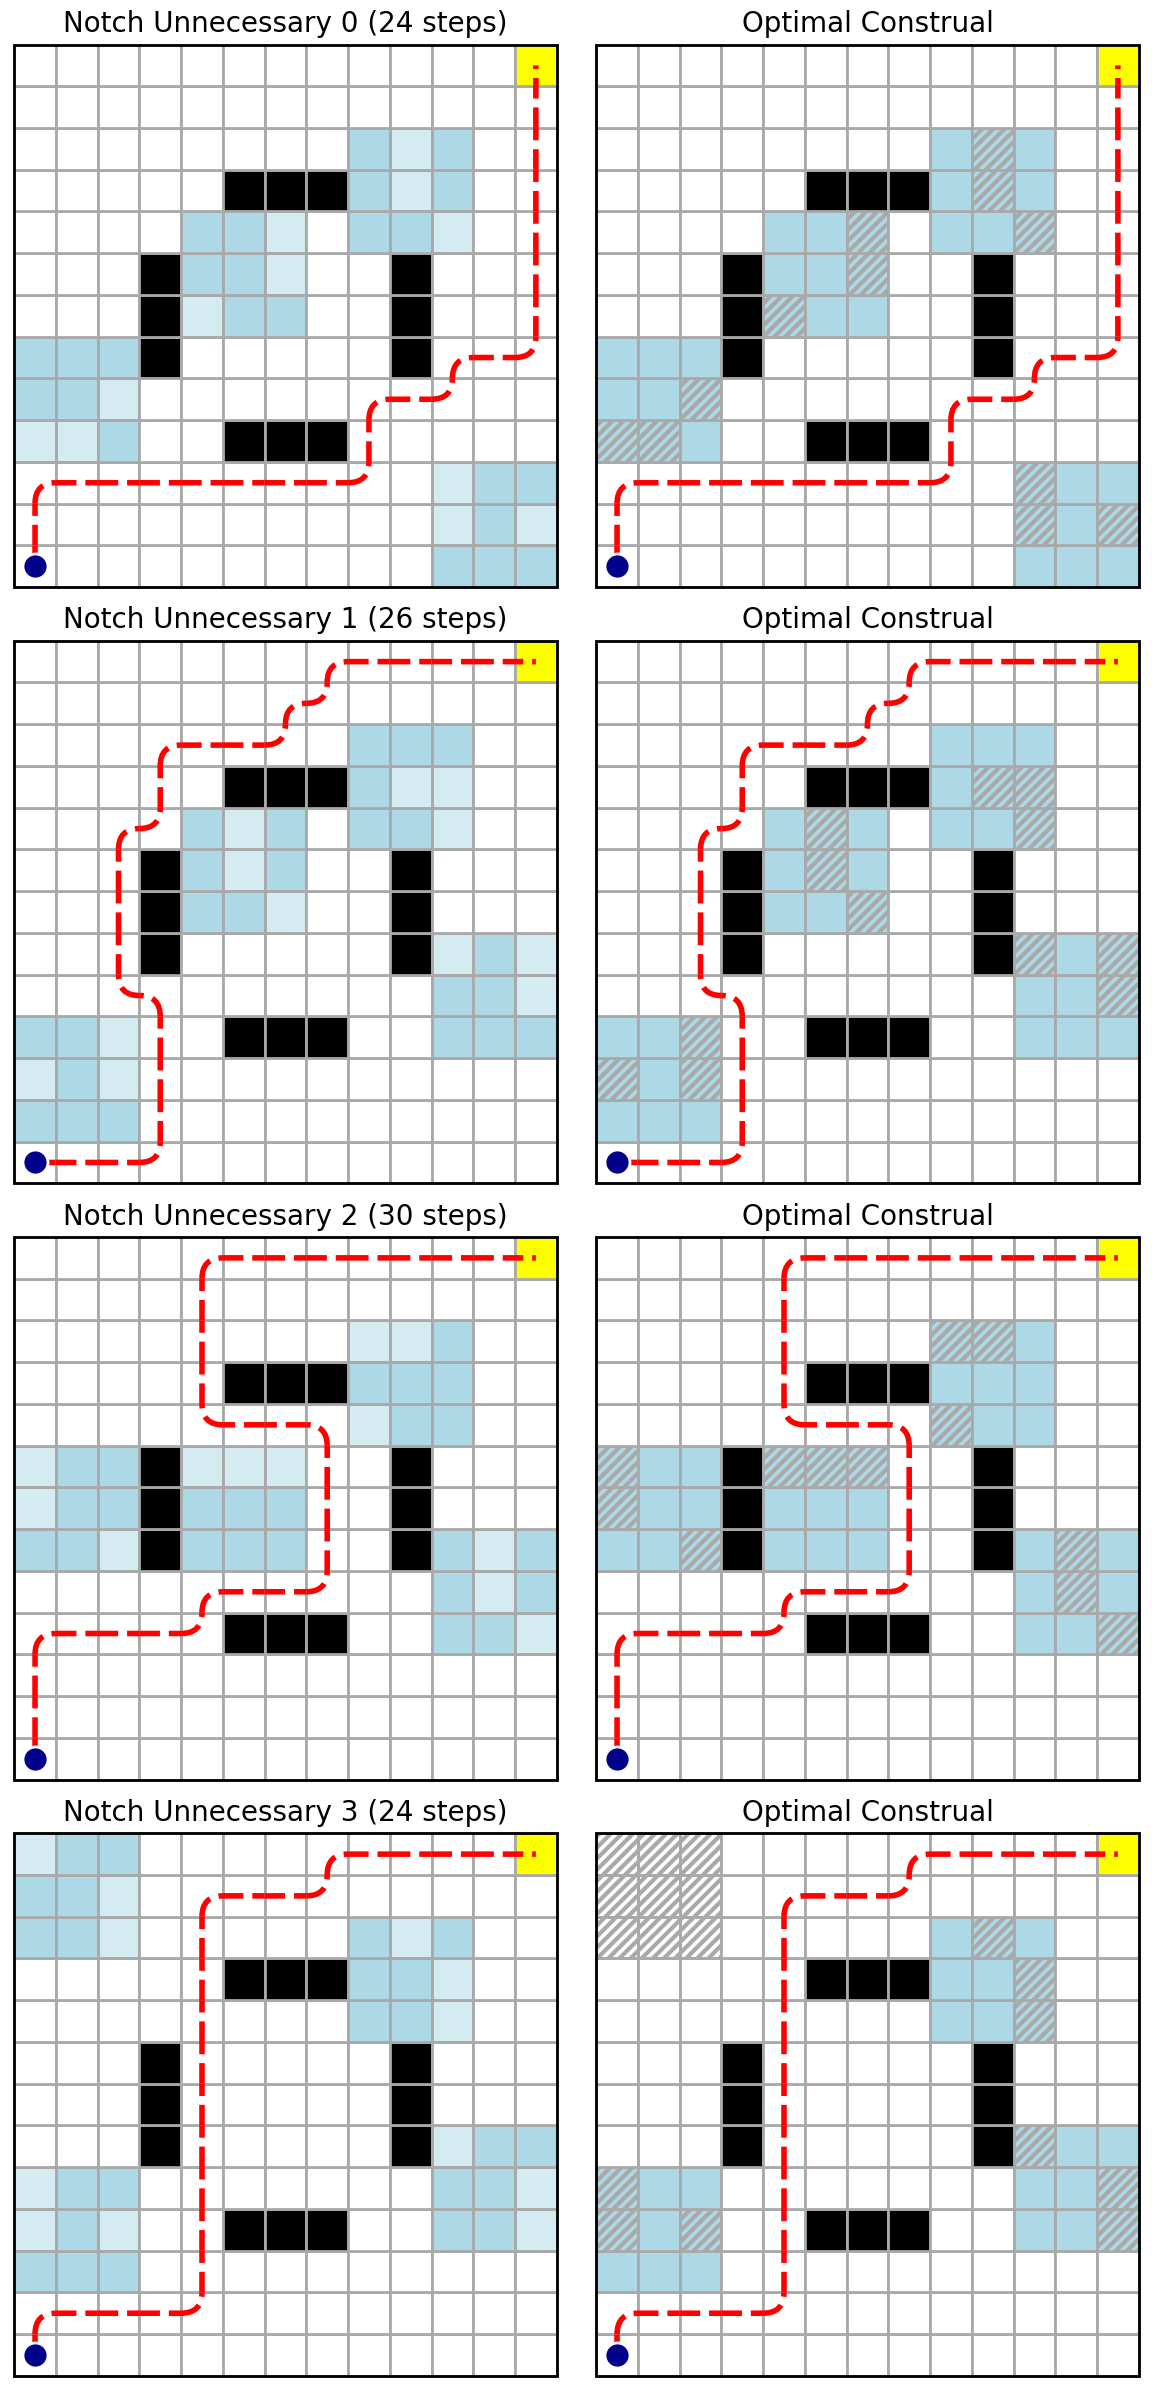

In [10]:
coarse_maze_stats = [s for s in maze_stats if 'coarse' in s['maze_name']]
fig, axes = plt.subplots(len(coarse_maze_stats)//2, 2, figsize=(6*2, 6*len(coarse_maze_stats)//2))
axes = list(axes)
for i, stats in enumerate(coarse_maze_stats[:4]):
    row_axes = axes[i]
    gw = GridWorld(
        tile_array=stats['tile_array'],
        **gw_params
    )
    gwp = gw.plot(
        ax=row_axes[0],
        featurecolors={
            **{c: MAIN_OBSTACLE_COLOR for c in "ABCDEFG"},
            **{c: BROKEN_OBSTACLE_COLOR for c in "abcdefg"},
            "#": 'k',
            '$': 'yellow'
        },
        plot_walls=False,
        plot_initial_states=False,
        plot_absorbing_states=False
    )
    gwp.ax.plot(
        .5, .5,
        color='darkblue',
        marker='o',
        markersize=18,
        markeredgewidth=2,
        mec='w',
    )
    gw_coarse = GridWorld(
        tile_array=stats['tile_array'],
        **{
            **gw_params,
            "wall_features": '#ABCDEFGHIJKabcdefg',
        }
    )
    coarse_policy = PolicyIteration().plan_on(gw_coarse).policy
    coarse_traj = coarse_policy.run_on(gw, rng=random.Random(12319))
    gwp.plot_trajectory(coarse_traj.state_traj, lw=4, ls='--', color='r', jitter_var=0)
    
    maze_idx = stats['maze_name'].split('-')[0]
    gwp.title(f"Notch Unnecessary {maze_idx} ({-int(sum(coarse_traj.reward))} steps)", fontsize=20)
    exp_con_ax = plot_wall_array(
        stats['coarse_wall_arr'], gw_params, stats['tile_array'], 
        ax=row_axes[1], 
    )
    # exp_con_ax.set_title(f"Expected no. of effects: {stats['coarse_exp_size']:.2f}", fontsize=20)
    exp_con_ax.set_title(f"Optimal Construal", fontsize=20)
    gwp = GridWorldPlotter(gw=gw_coarse, ax=exp_con_ax)
    gwp.plot_trajectory(coarse_traj.state_traj, lw=4, ls='--', color='r', jitter_var=0)
    gwp.ax.plot(
        .5, .5,
        color='darkblue',
        marker='o',
        markersize=18,
        markeredgewidth=2,
        mec='w',
    )
plt.tight_layout()
plt.savefig("./figures/coarse-train_0-3.png", dpi=300, transparent=False, facecolor='w')

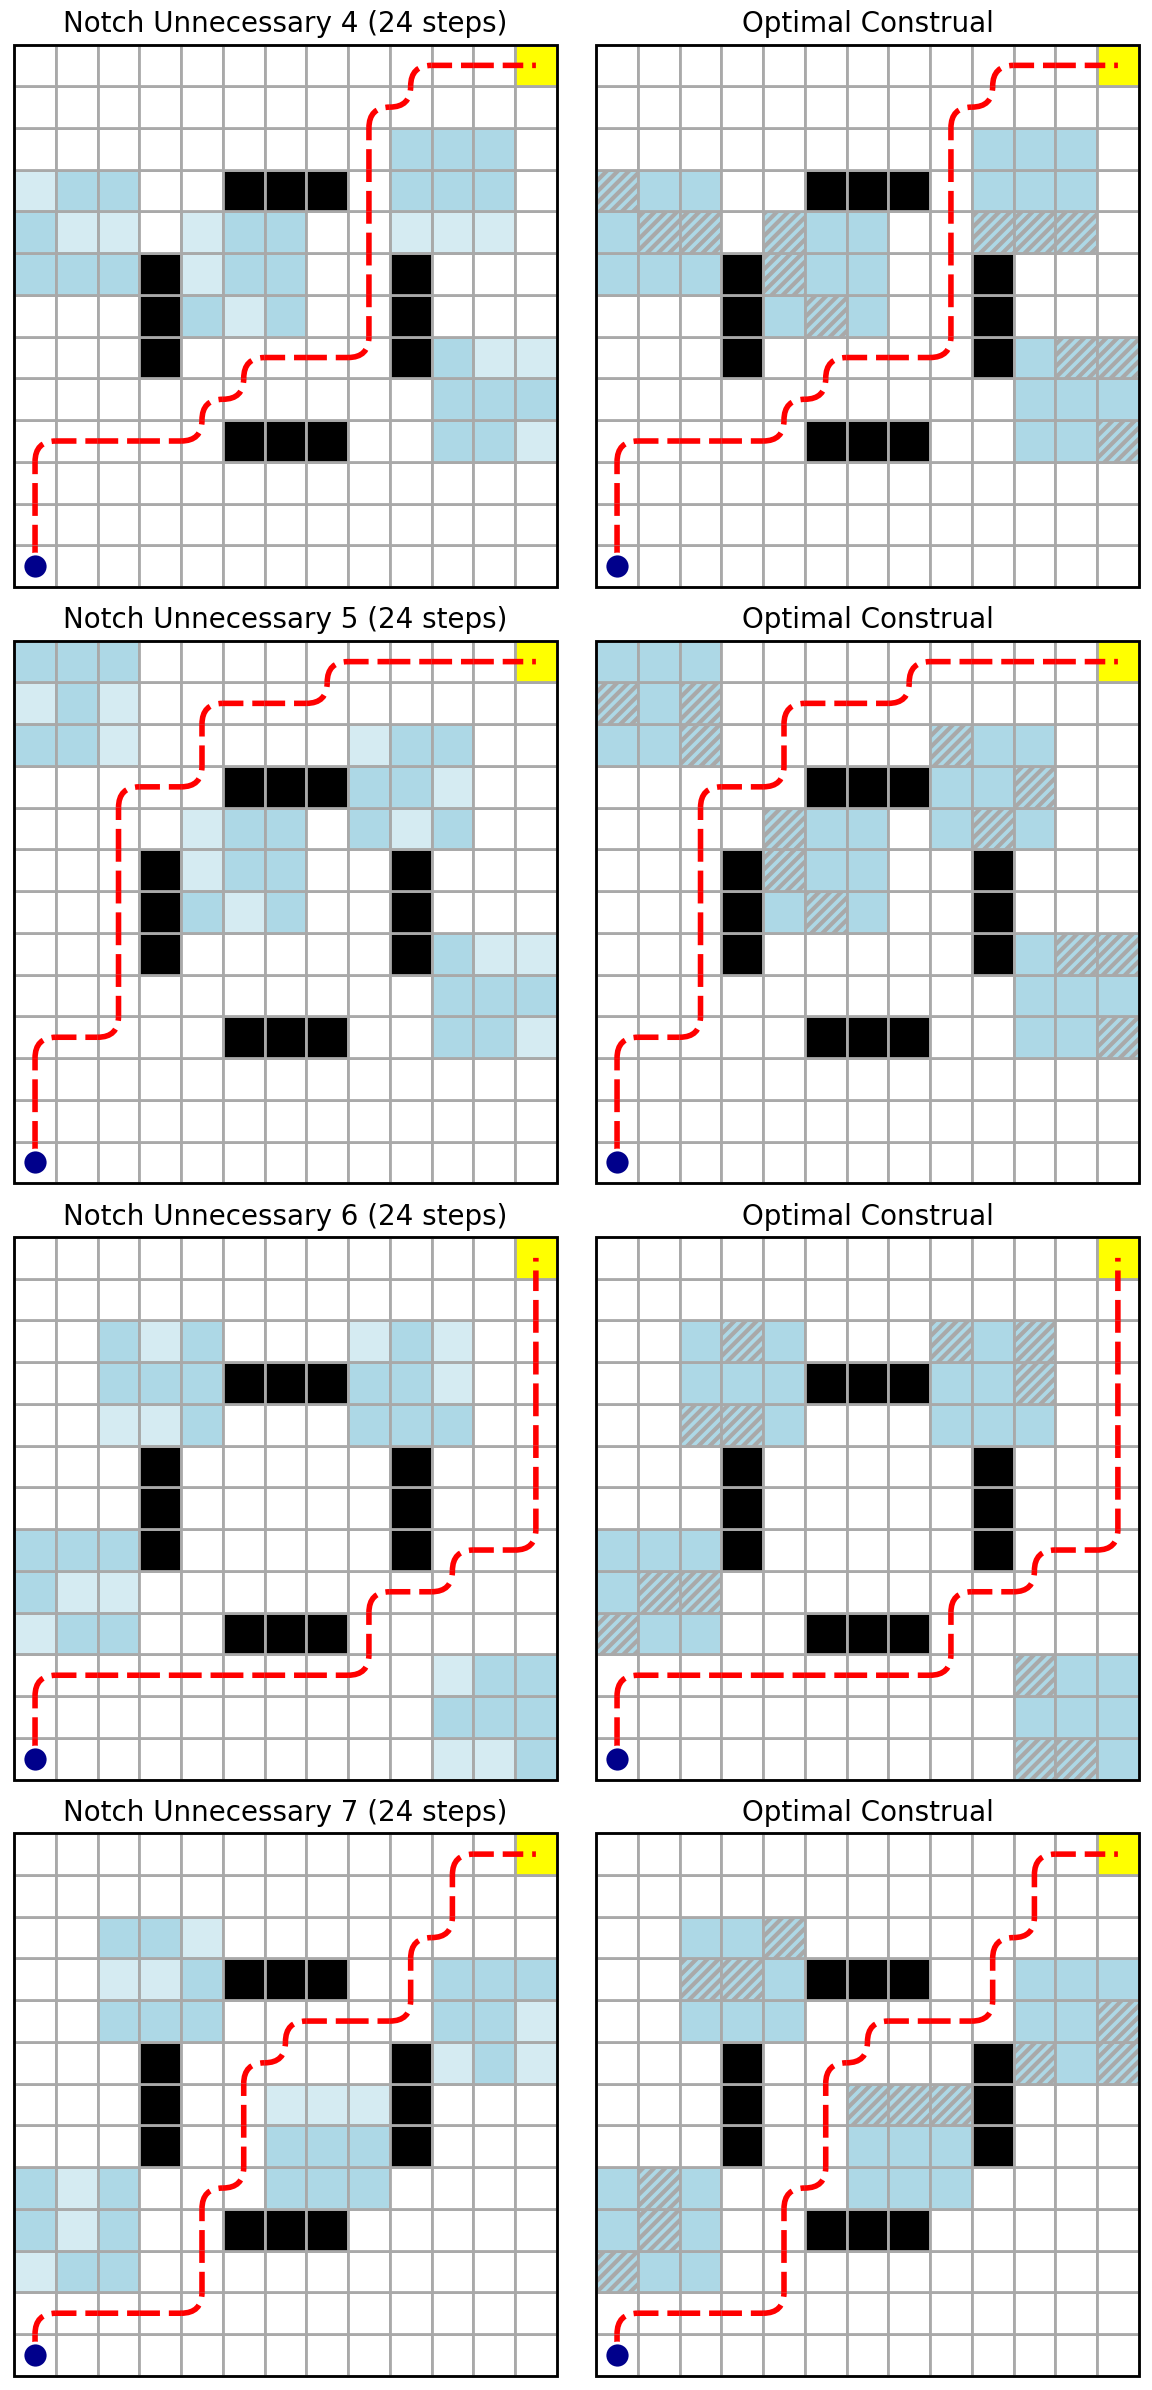

In [11]:
coarse_maze_stats = [s for s in maze_stats if 'coarse' in s['maze_name']]
fig, axes = plt.subplots(len(coarse_maze_stats)//2, 2, figsize=(6*2, 6*len(coarse_maze_stats)//2))
axes = list(axes)
for i, stats in enumerate(coarse_maze_stats[4:]):
    row_axes = axes[i]
    gw = GridWorld(
        tile_array=stats['tile_array'],
        **gw_params
    )
    gwp = gw.plot(
        ax=row_axes[0],
        featurecolors={
            **{c: MAIN_OBSTACLE_COLOR for c in "ABCDEFG"},
            **{c: BROKEN_OBSTACLE_COLOR for c in "abcdefg"},
            "#": 'k',
            '$': 'yellow'
        },
        plot_walls=False,
        plot_initial_states=False,
        plot_absorbing_states=False
    )
    gwp.ax.plot(
        .5, .5,
        color='darkblue',
        marker='o',
        markersize=18,
        markeredgewidth=2,
        mec='w',
    )
    gw_coarse = GridWorld(
        tile_array=stats['tile_array'],
        **{
            **gw_params,
            "wall_features": '#ABCDEFGHIJKabcdefg',
        }
    )
    coarse_policy = PolicyIteration().plan_on(gw_coarse).policy
    coarse_traj = coarse_policy.run_on(gw, rng=random.Random(12319))
    gwp.plot_trajectory(coarse_traj.state_traj, lw=4, ls='--', color='r', jitter_var=0)
    
    maze_idx = stats['maze_name'].split('-')[0]
    gwp.title(f"Notch Unnecessary {maze_idx} ({-int(sum(coarse_traj.reward))} steps)", fontsize=20)
    exp_con_ax = plot_wall_array(
        stats['coarse_wall_arr'], gw_params, stats['tile_array'], 
        ax=row_axes[1],
    )
    # exp_con_ax.set_title(f"Expected no. of effects: {stats['coarse_exp_size']:.2f}", fontsize=20)
    exp_con_ax.set_title(f"Optimal Construal", fontsize=20)
    gwp = GridWorldPlotter(gw=gw_coarse, ax=exp_con_ax)
    gwp.plot_trajectory(coarse_traj.state_traj, lw=4, ls='--', color='r', jitter_var=0)
    gwp.ax.plot(
        .5, .5,
        color='darkblue',
        marker='o',
        markersize=18,
        markeredgewidth=2,
        mec='w',
    )
plt.tight_layout()
plt.savefig("./figures/coarse-train_4-7.png", dpi=300, transparent=False, facecolor='w')

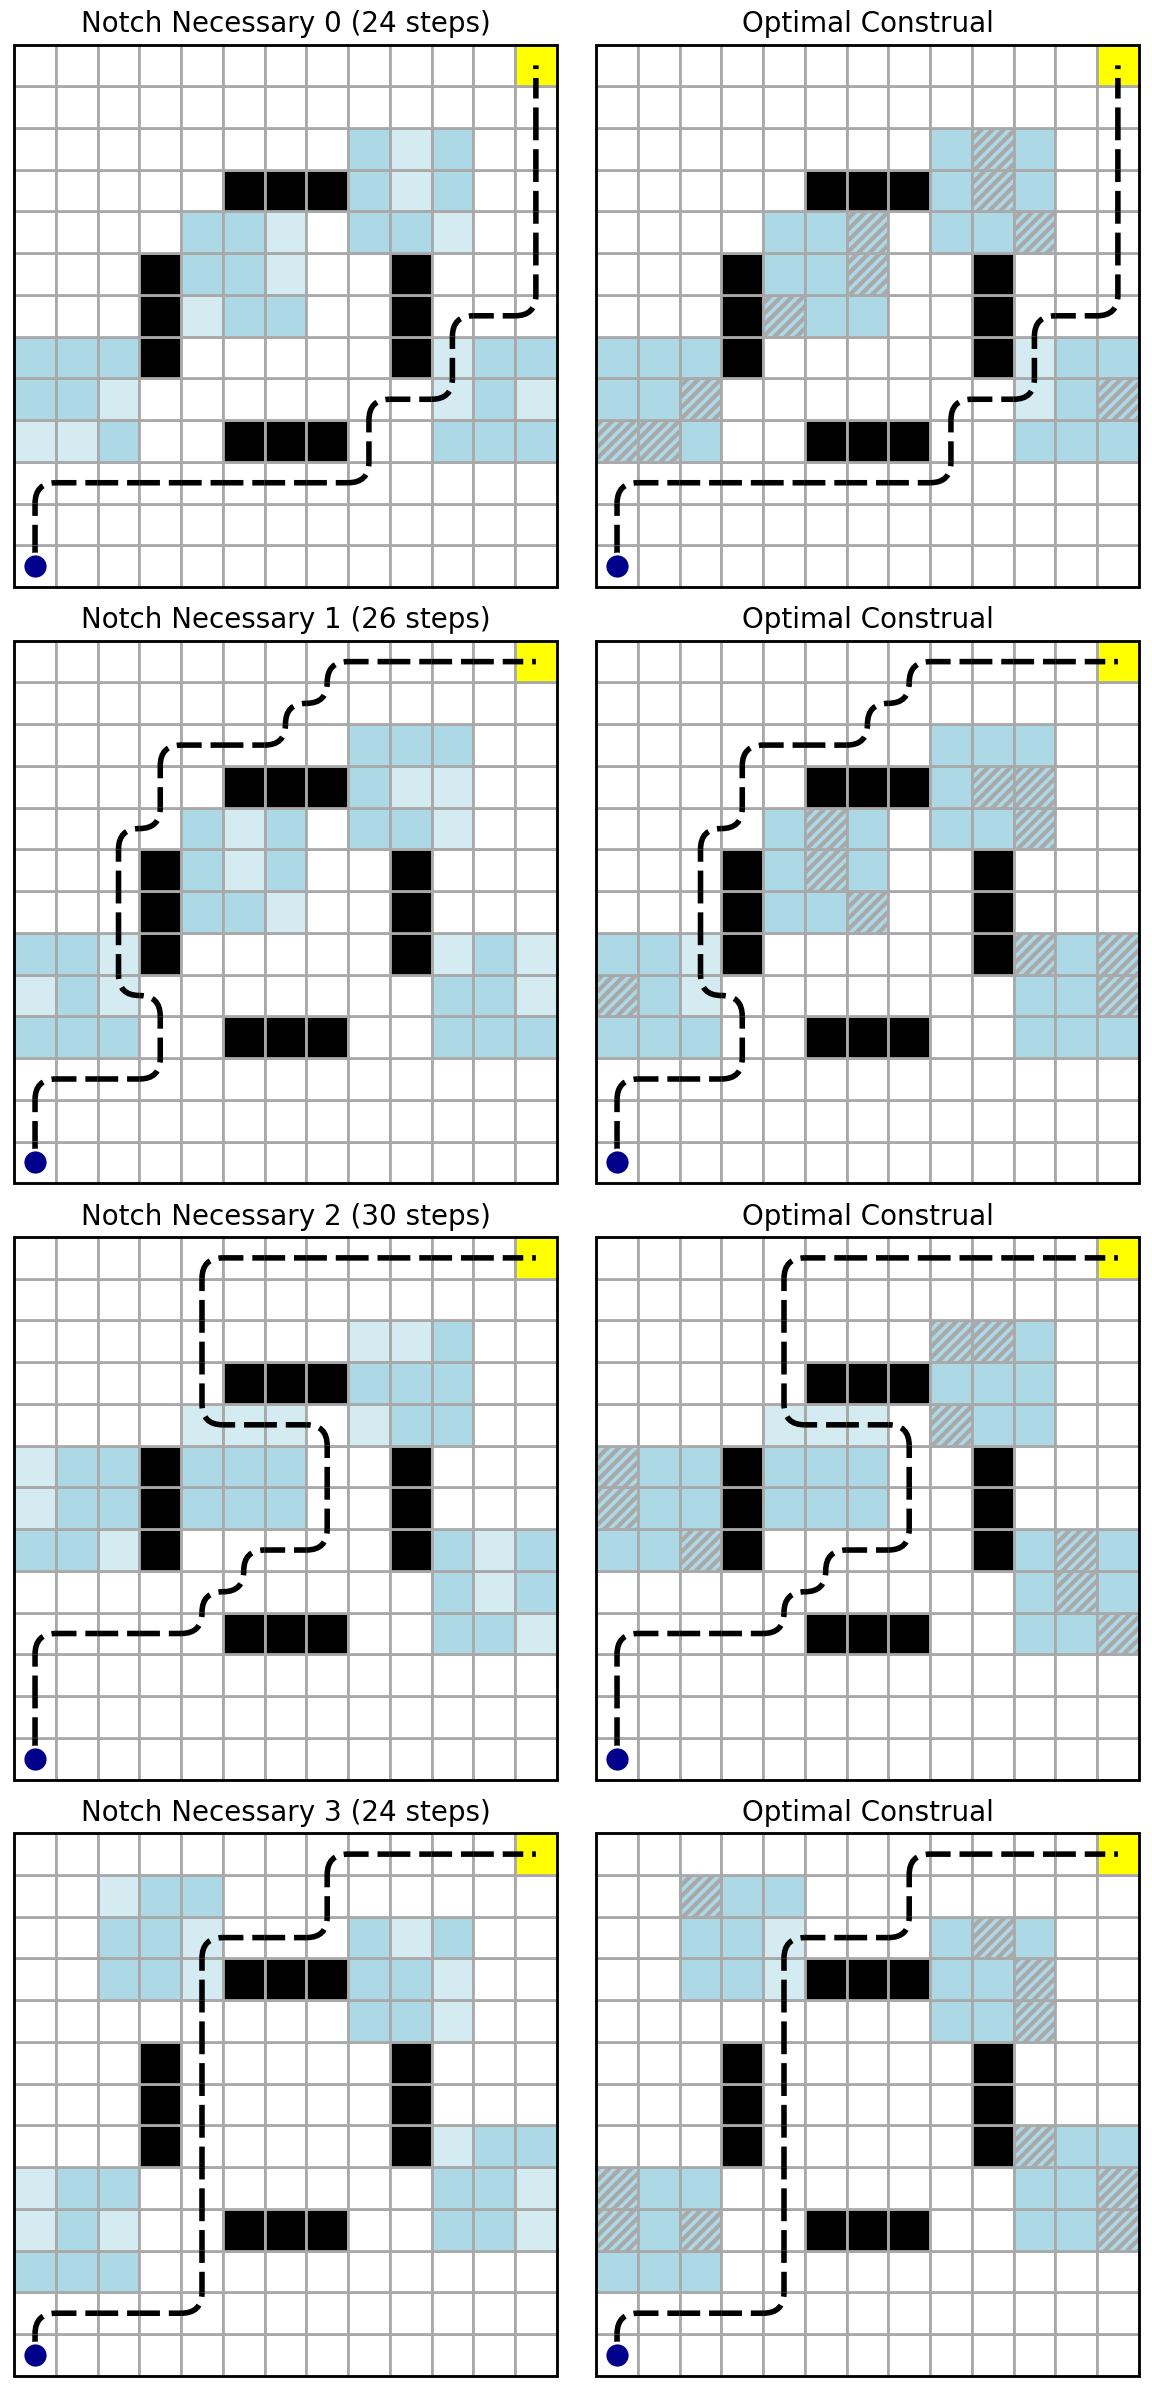

In [12]:
fine_maze_stats = [s for s in maze_stats if 'fine' in s['maze_name']]
fig, axes = plt.subplots(len(fine_maze_stats)//2, 2, figsize=(6*2, 6*len(fine_maze_stats)//2))
axes = list(axes)
for i, stats in enumerate(fine_maze_stats[:4]):
    row_axes = axes[i]
    gw = GridWorld(
        tile_array=stats['tile_array'],
        **gw_params
    )
    gwp = gw.plot(
        ax=row_axes[0],
        featurecolors={
            **{c: MAIN_OBSTACLE_COLOR for c in "ABCDEFG"},
            **{c: BROKEN_OBSTACLE_COLOR for c in "abcdefg"},
            "#": 'k',
            '$': 'yellow'
        },
        plot_walls=False,
        plot_initial_states=False,
        plot_absorbing_states=False
    )
    gwp.ax.plot(
        .5, .5,
        color='darkblue',
        marker='o',
        markersize=18,
        markeredgewidth=2,
        mec='w',
    )
    policy = PolicyIteration().plan_on(gw).policy
    traj = policy.run_on(gw, rng=random.Random(12319))
    gwp.plot_trajectory(traj.state_traj, lw=4, ls='--', color='k', jitter_var=0)
    
    maze_idx = stats['maze_name'].split('-')[0]
    gwp.title(f"Notch Necessary {maze_idx} ({-int(sum(traj.reward))} steps)", fontsize=20)
    exp_con_ax = plot_wall_array(
        stats['fine_wall_arr'], gw_params, stats['tile_array'], 
        ax=row_axes[1],
    )
    # exp_con_ax.set_title(f"Expected no. of effects: {stats['fine_exp_size']:.2f}", fontsize=20)
    exp_con_ax.set_title(f"Optimal Construal", fontsize=20)
    gwp = GridWorldPlotter(gw=gw, ax=exp_con_ax)
    gwp.plot_trajectory(traj.state_traj, lw=4, ls='--', color='k', jitter_var=0)
    gwp.ax.plot(
        .5, .5,
        color='darkblue',
        marker='o',
        markersize=18,
        markeredgewidth=2,
        mec='w',
    )
plt.tight_layout()
plt.savefig("./figures/fine-train_0-3.png", dpi=300, transparent=False, facecolor='w')

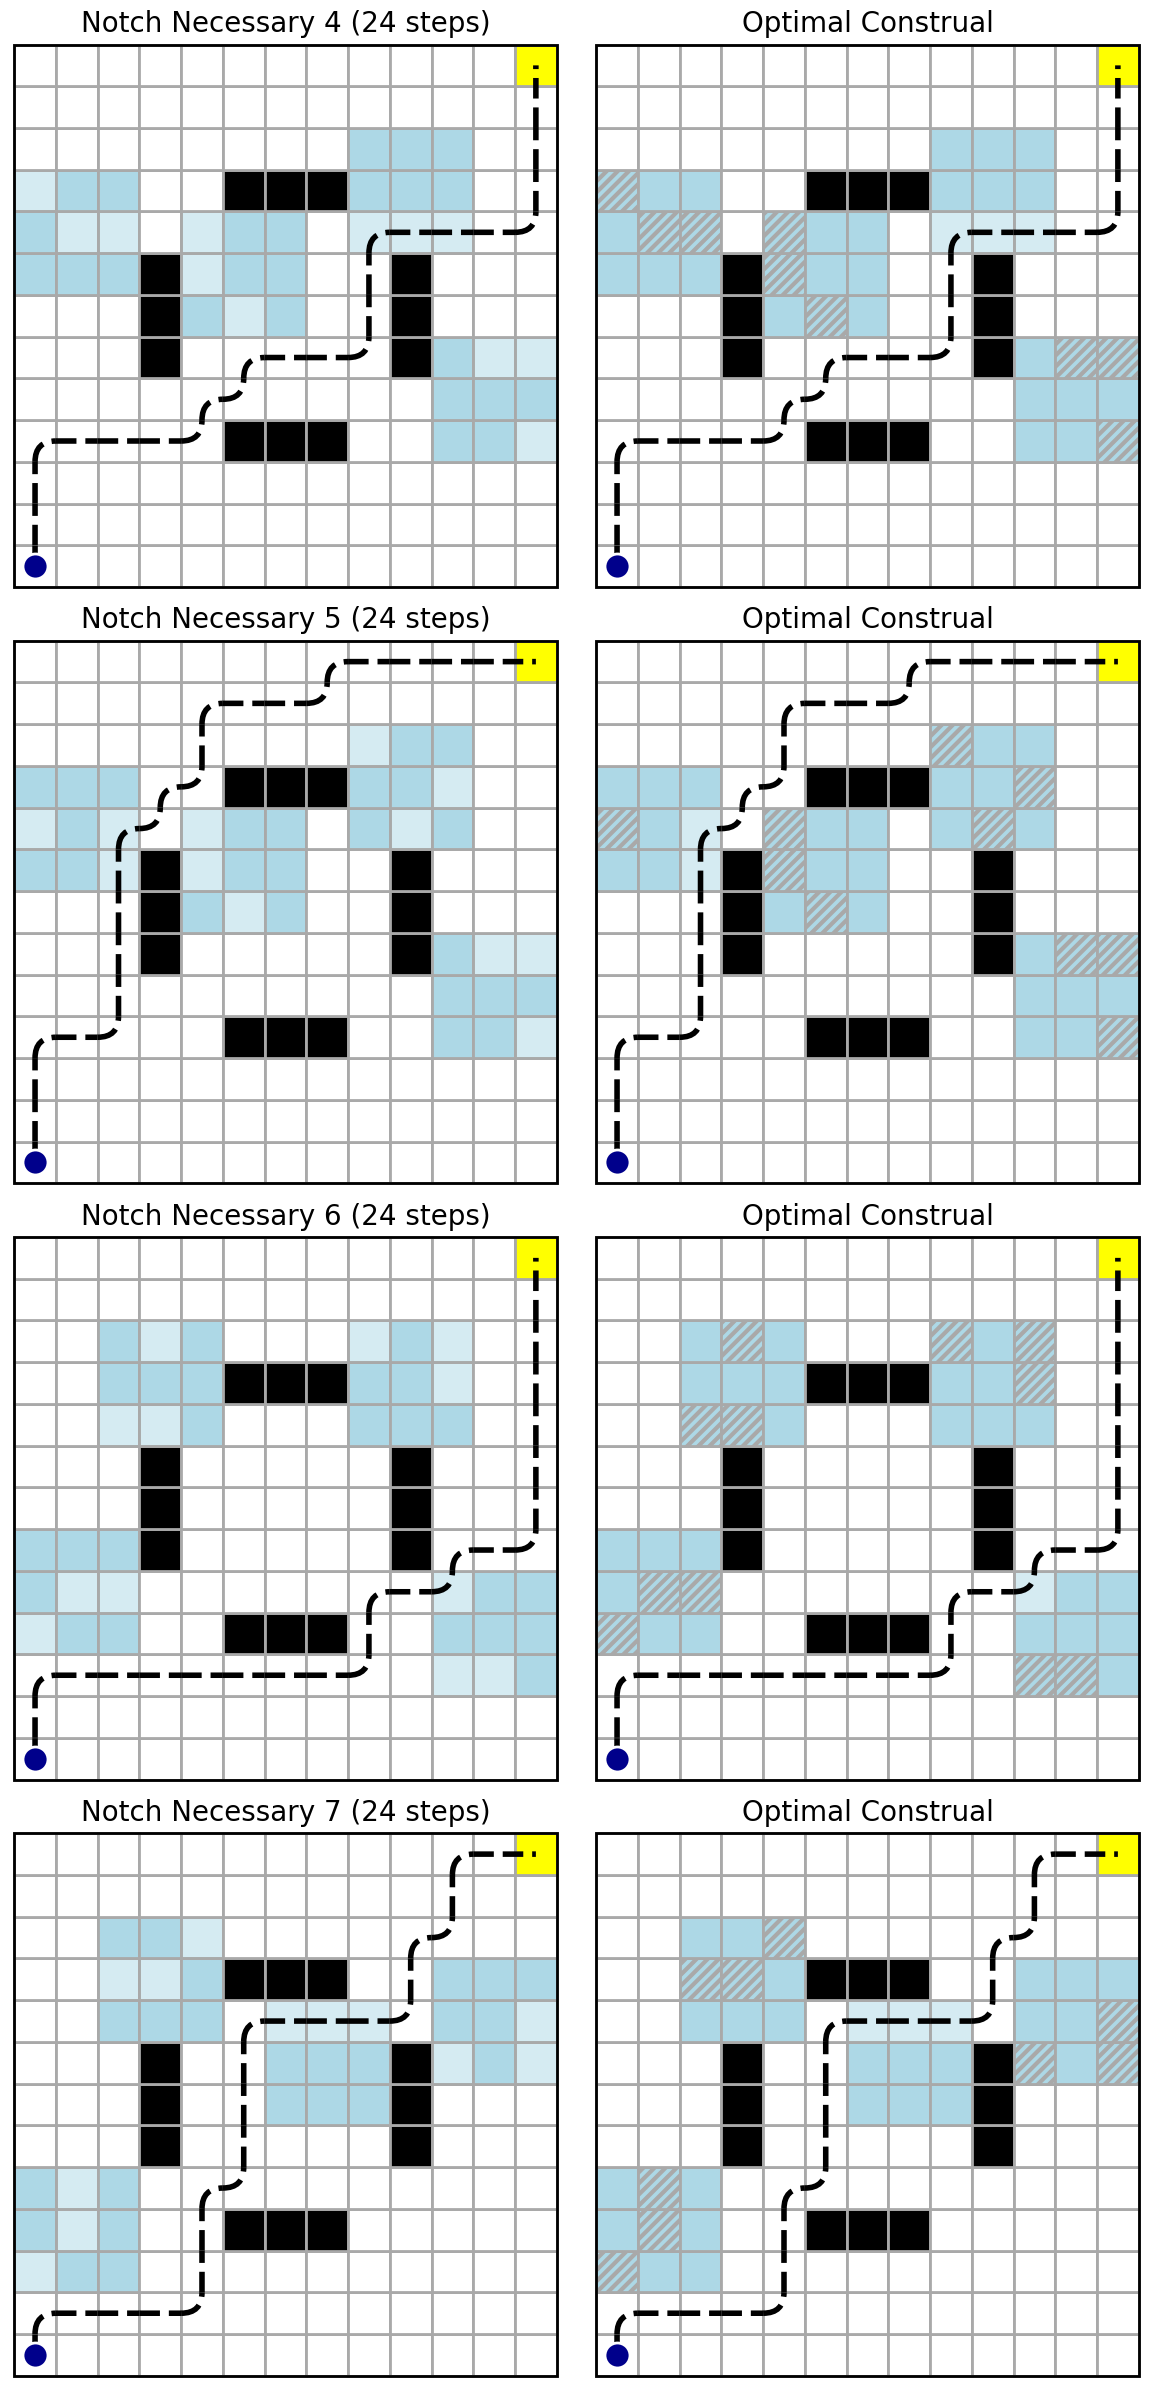

In [13]:
fine_maze_stats = [s for s in maze_stats if 'fine' in s['maze_name']]
fig, axes = plt.subplots(len(fine_maze_stats)//2, 2, figsize=(6*2, 6*len(fine_maze_stats)//2))
axes = list(axes)
for i, stats in enumerate(fine_maze_stats[4:]):
    row_axes = axes[i]
    gw = GridWorld(
        tile_array=stats['tile_array'],
        **gw_params
    )
    gwp = gw.plot(
        ax=row_axes[0],
        featurecolors={
            **{c: MAIN_OBSTACLE_COLOR for c in "ABCDEFG"},
            **{c: BROKEN_OBSTACLE_COLOR for c in "abcdefg"},
            "#": 'k',
            '$': 'yellow'
        },
        plot_walls=False,
        plot_initial_states=False,
        plot_absorbing_states=False
    )
    gwp.ax.plot(
        .5, .5,
        color='darkblue',
        marker='o',
        markersize=18,
        markeredgewidth=2,
        mec='w',
    )
    policy = PolicyIteration().plan_on(gw).policy
    traj = policy.run_on(gw, rng=random.Random(12319))
    gwp.plot_trajectory(traj.state_traj, lw=4, ls='--', color='k', jitter_var=0)
    
    maze_idx = stats['maze_name'].split('-')[0]
    gwp.title(f"Notch Necessary {maze_idx} ({-int(sum(traj.reward))} steps)", fontsize=20)
    exp_con_ax = plot_wall_array(
        stats['fine_wall_arr'], gw_params, stats['tile_array'], 
        ax=row_axes[1],
    )
    # exp_con_ax.set_title(f"Expected no. of effects: {stats['fine_exp_size']:.2f}", fontsize=20)
    exp_con_ax.set_title(f"Optimal Construal", fontsize=20)
    gwp = GridWorldPlotter(gw=gw, ax=exp_con_ax)
    gwp.plot_trajectory(traj.state_traj, lw=4, ls='--', color='k', jitter_var=0)
    gwp.ax.plot(
        .5, .5,
        color='darkblue',
        marker='o',
        markersize=18,
        markeredgewidth=2,
        mec='w',
    )
plt.tight_layout()
plt.savefig("./figures/fine-train_4-7.png", dpi=300, transparent=False, facecolor='w')

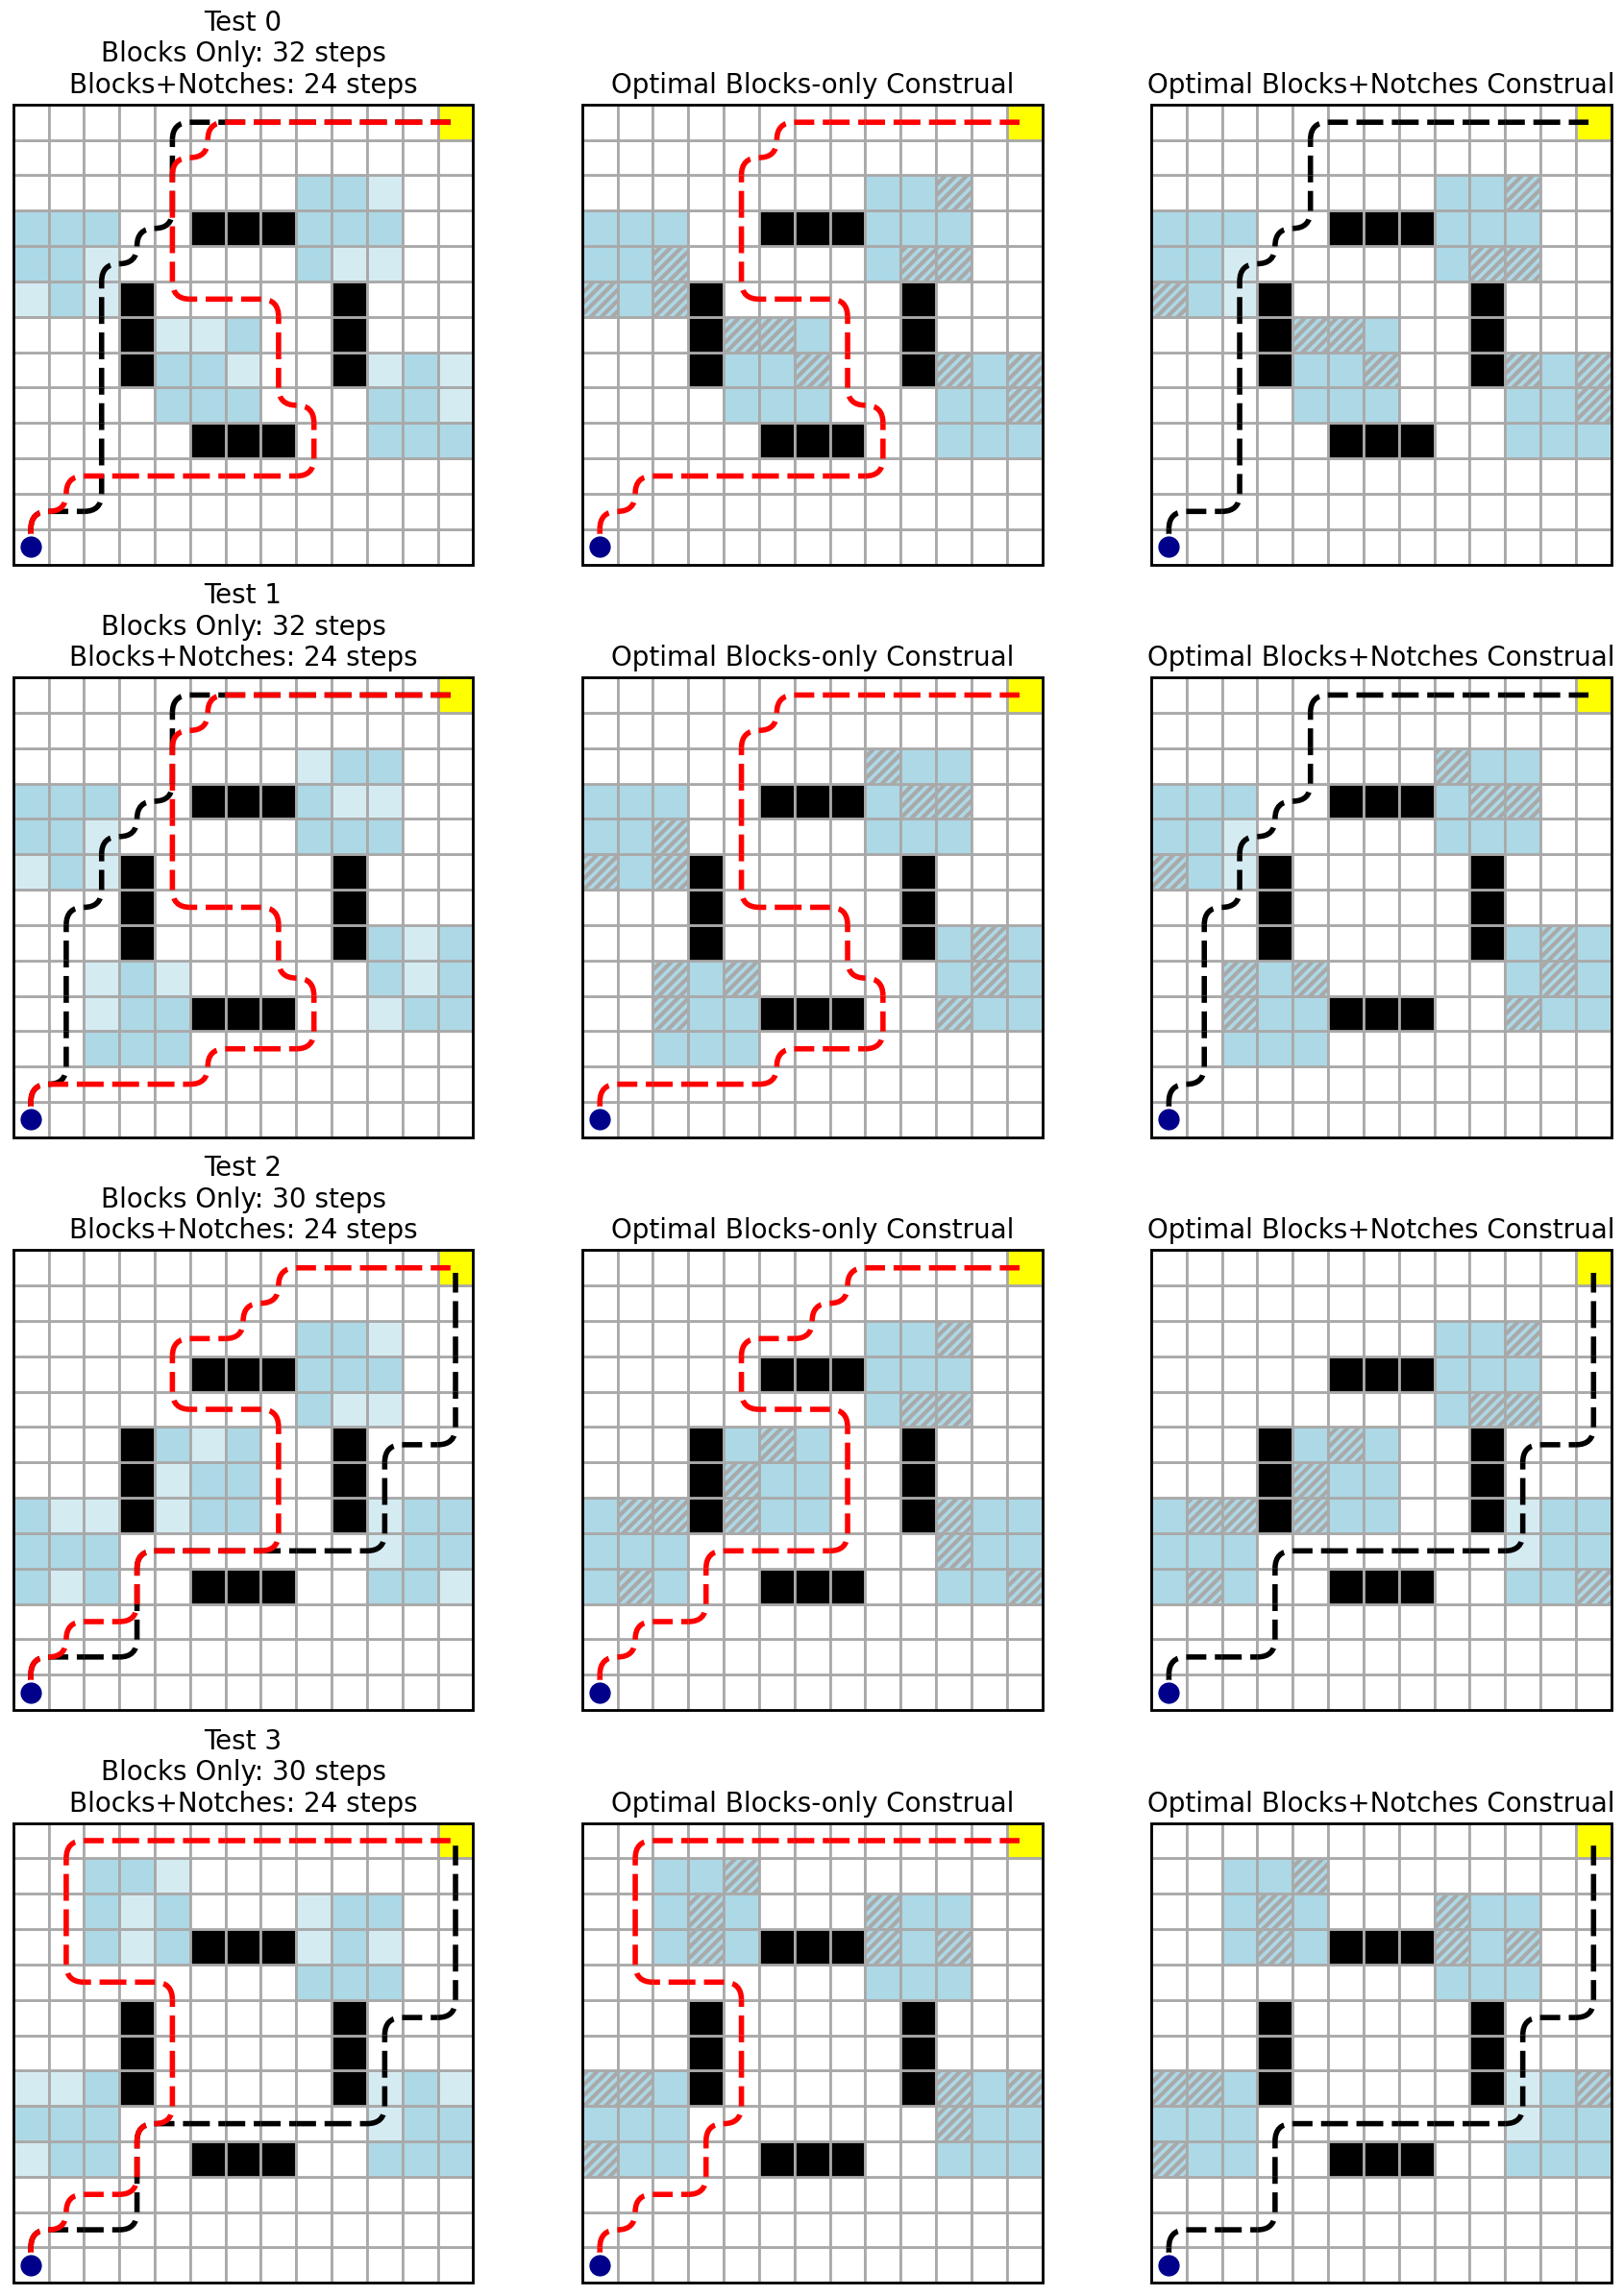

In [17]:
test_maze_stats = [s for s in maze_stats if 'test' in s['maze_name']]
fig, axes = plt.subplots(len(test_maze_stats), 3, figsize=(6*3, 6*len(test_maze_stats)))
axes = list(axes)
for i, stats in enumerate(test_maze_stats):
    row_axes = axes[i]
    gw = GridWorld(
        tile_array=stats['tile_array'],
        **gw_params
    )
    gwp = gw.plot(
        ax=row_axes[0],
        featurecolors={
            **{c: MAIN_OBSTACLE_COLOR for c in "ABCDEFG"},
            **{c: BROKEN_OBSTACLE_COLOR for c in "abcdefg"},
            "#": 'k',
            '$': 'yellow'
        },
        plot_walls=False,
        plot_initial_states=False,
        plot_absorbing_states=False
    )
    gwp.ax.plot(
        .5, .5,
        color='darkblue',
        marker='o',
        markersize=18,
        markeredgewidth=2,
        mec='w',
    )
    fine_policy = PolicyIteration().plan_on(gw).policy
    fine_traj = fine_policy.run_on(gw, rng=random.Random(0))
    gwp.plot_trajectory(fine_traj.state_traj, lw=4, ls='--', color='k', jitter_var=0)
    gw_coarse = GridWorld(
        tile_array=stats['tile_array'],
        **{
            **gw_params,
            "wall_features": '#ABCDEFGHIJKabcdefg',
        }
    )
    coarse_policy = PolicyIteration().plan_on(gw_coarse).policy
    coarse_traj = coarse_policy.run_on(gw, rng=random.Random(29119))
    gwp.plot_trajectory(coarse_traj.state_traj, lw=4, ls='--', color='r', jitter_var=0)
    
    
    maze_idx = stats['maze_name'].split('-')[0]
    gwp.title(f"Test {maze_idx}\nBlocks Only: {-int(sum(coarse_traj.reward))} steps\nBlocks+Notches: {-int(sum(fine_traj.reward))} steps", fontsize=20)
    
    # exp_con_ax.set_title(f"Expected no. of effects: {stats['fine_exp_size']:.2f}", fontsize=20)
    exp_coarse_con_ax = plot_wall_array(
        stats['coarse_wall_arr'], gw_params, stats['tile_array'], 
        ax=row_axes[1],
    )
    gwp = GridWorldPlotter(gw=gw, ax=exp_coarse_con_ax)
    gwp.plot_trajectory(coarse_traj.state_traj, lw=4, ls='--', color='r', jitter_var=0)
    gwp.ax.plot(
        .5, .5,
        color='darkblue',
        marker='o',
        markersize=18,
        markeredgewidth=2,
        mec='w',
    )
    # exp_coarse_con_ax.set_title(f"Exp. no. effects (coarse): {stats['coarse_exp_size']:.2f}", fontsize=20)
    exp_coarse_con_ax.set_title(f"Optimal Blocks-only Construal", fontsize=20)
    exp_fine_con_ax = plot_wall_array(
        stats['fine_wall_arr'], gw_params, stats['tile_array'], 
        ax=row_axes[2],
    )
    # exp_fine_con_ax.set_title(f"Exp. no. effects (fine): {stats['fine_exp_size']:.2f}", fontsize=20)
    exp_fine_con_ax.set_title(f"Optimal Blocks+Notches Construal", fontsize=20)
    gwp = GridWorldPlotter(gw=gw, ax=exp_fine_con_ax)
    gwp.plot_trajectory(fine_traj.state_traj, lw=4, ls='--', color='k', jitter_var=0)
    gwp.ax.plot(
        .5, .5,
        color='darkblue',
        marker='o',
        markersize=18,
        markeredgewidth=2,
        mec='w',
    )
plt.tight_layout()
plt.savefig("./figures/fine-test_0-3.png", dpi=300, transparent=False, facecolor='w')

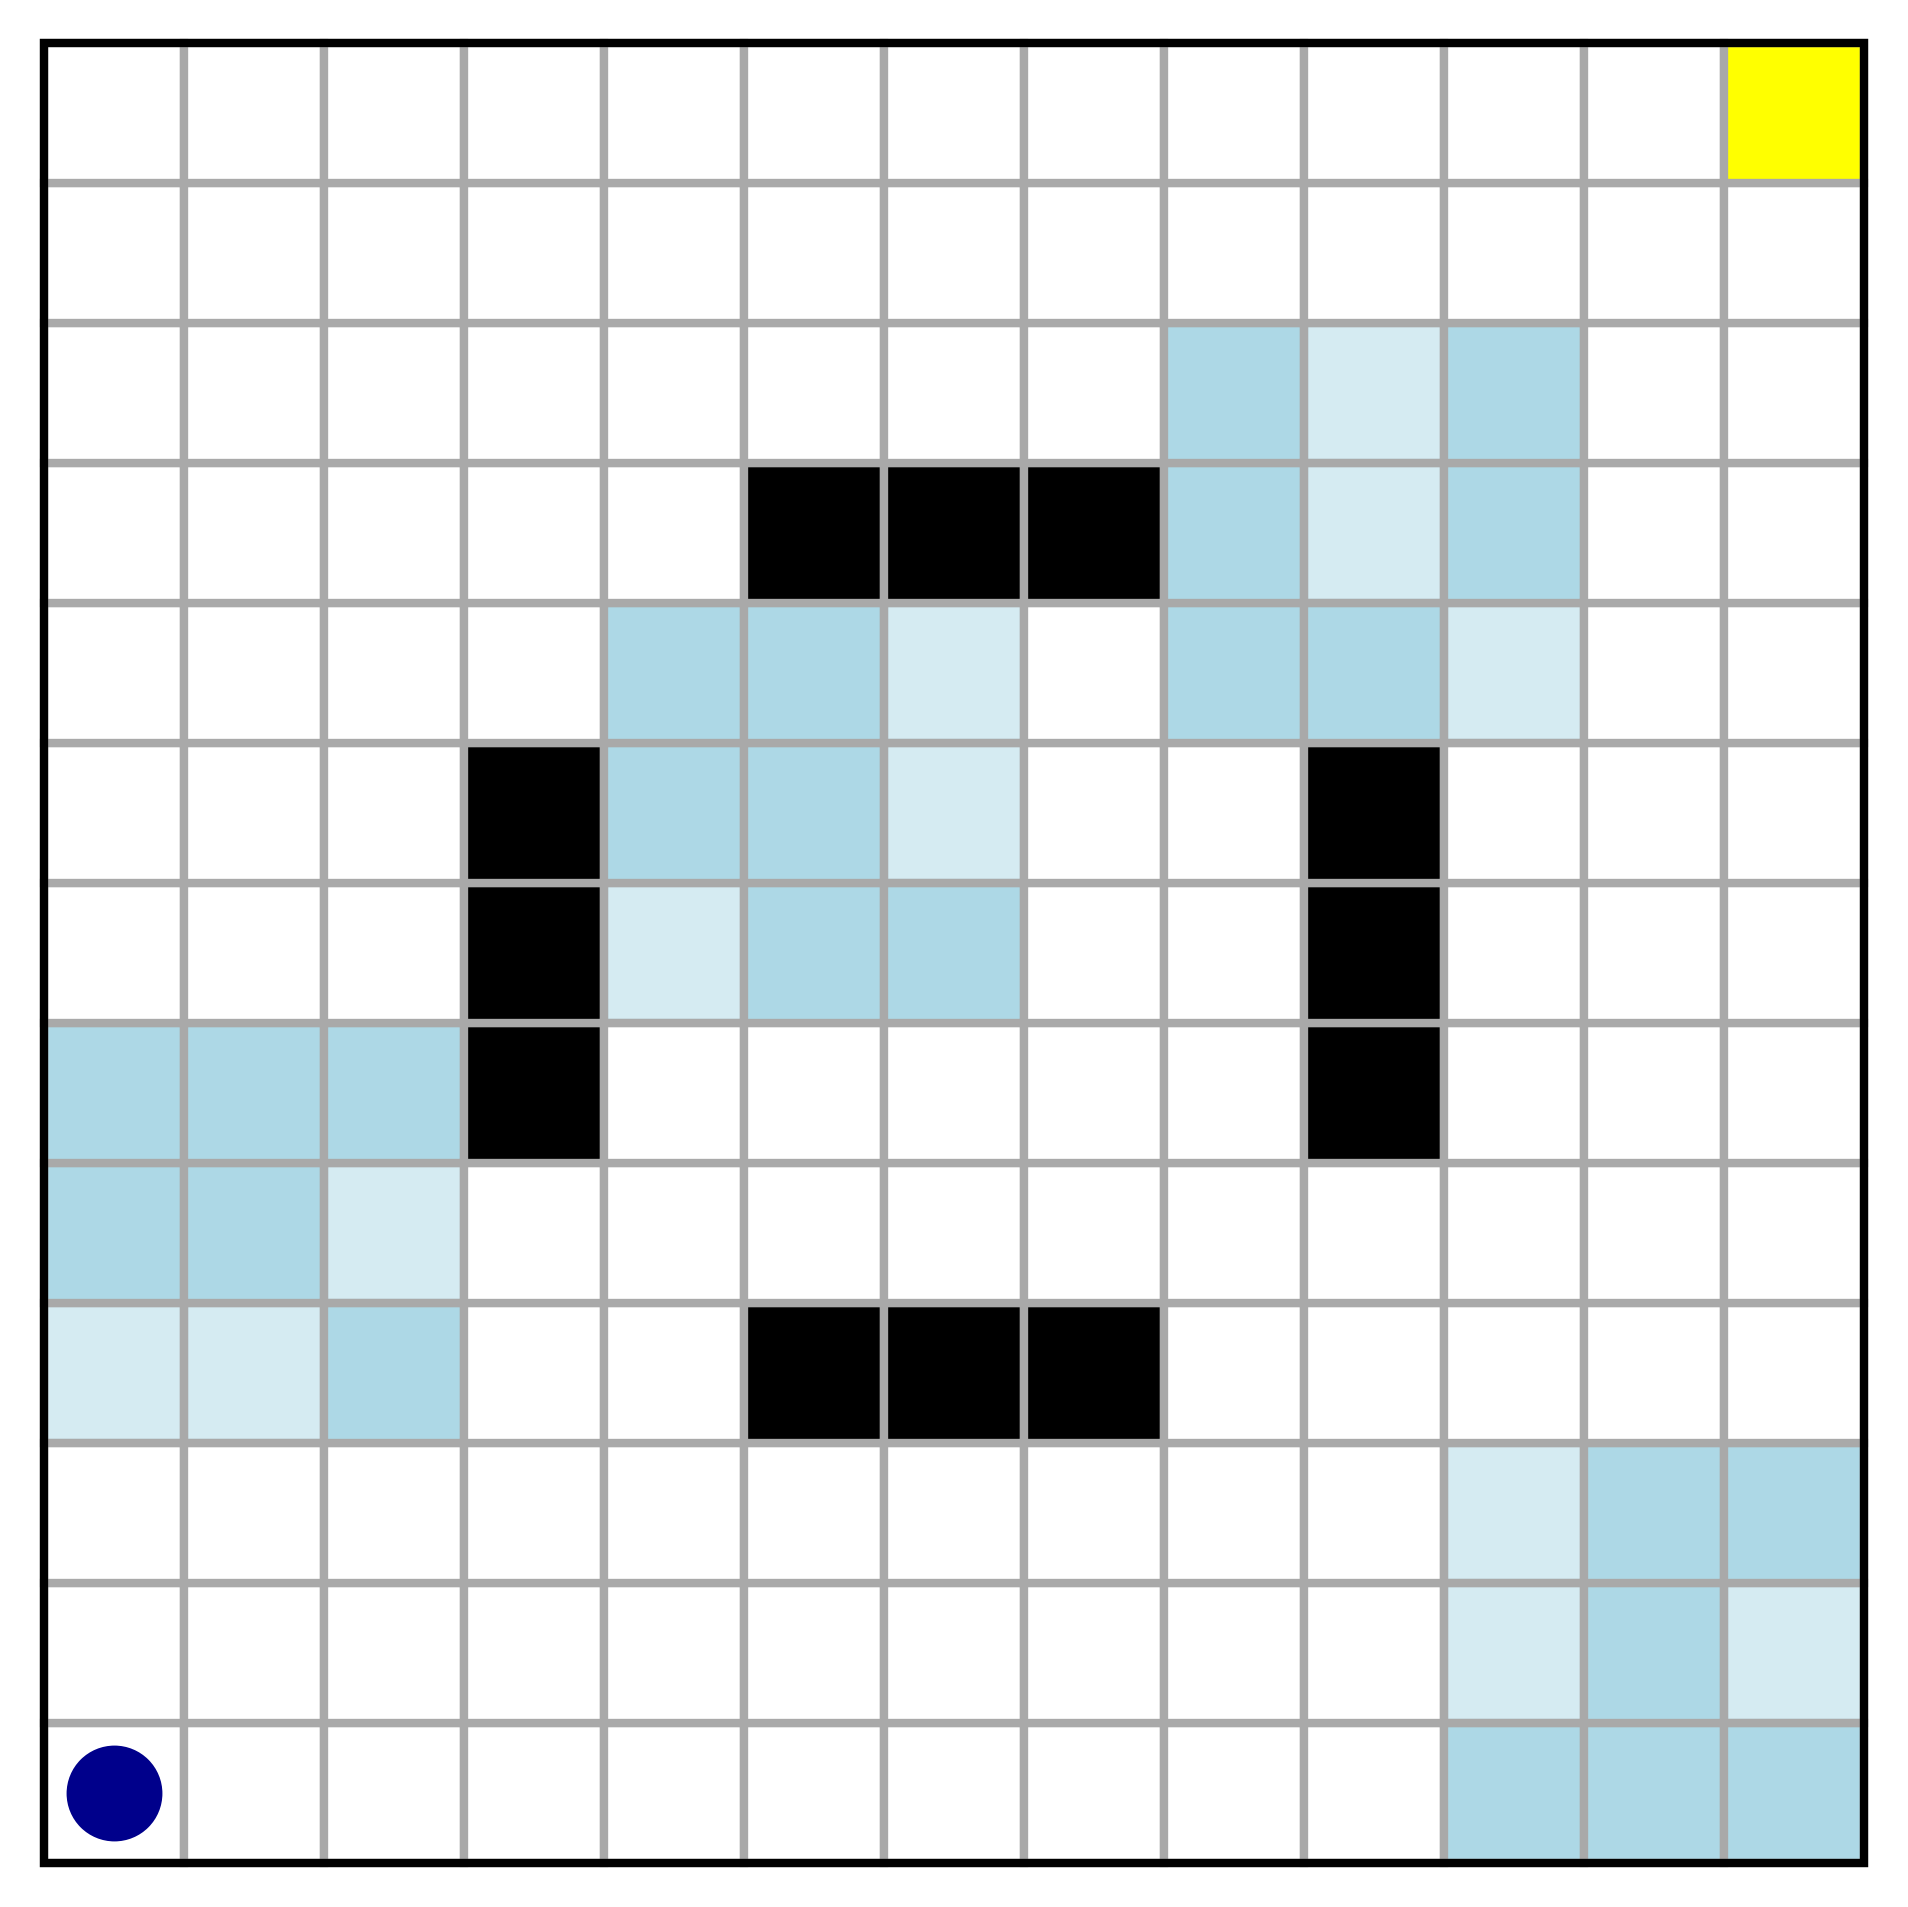

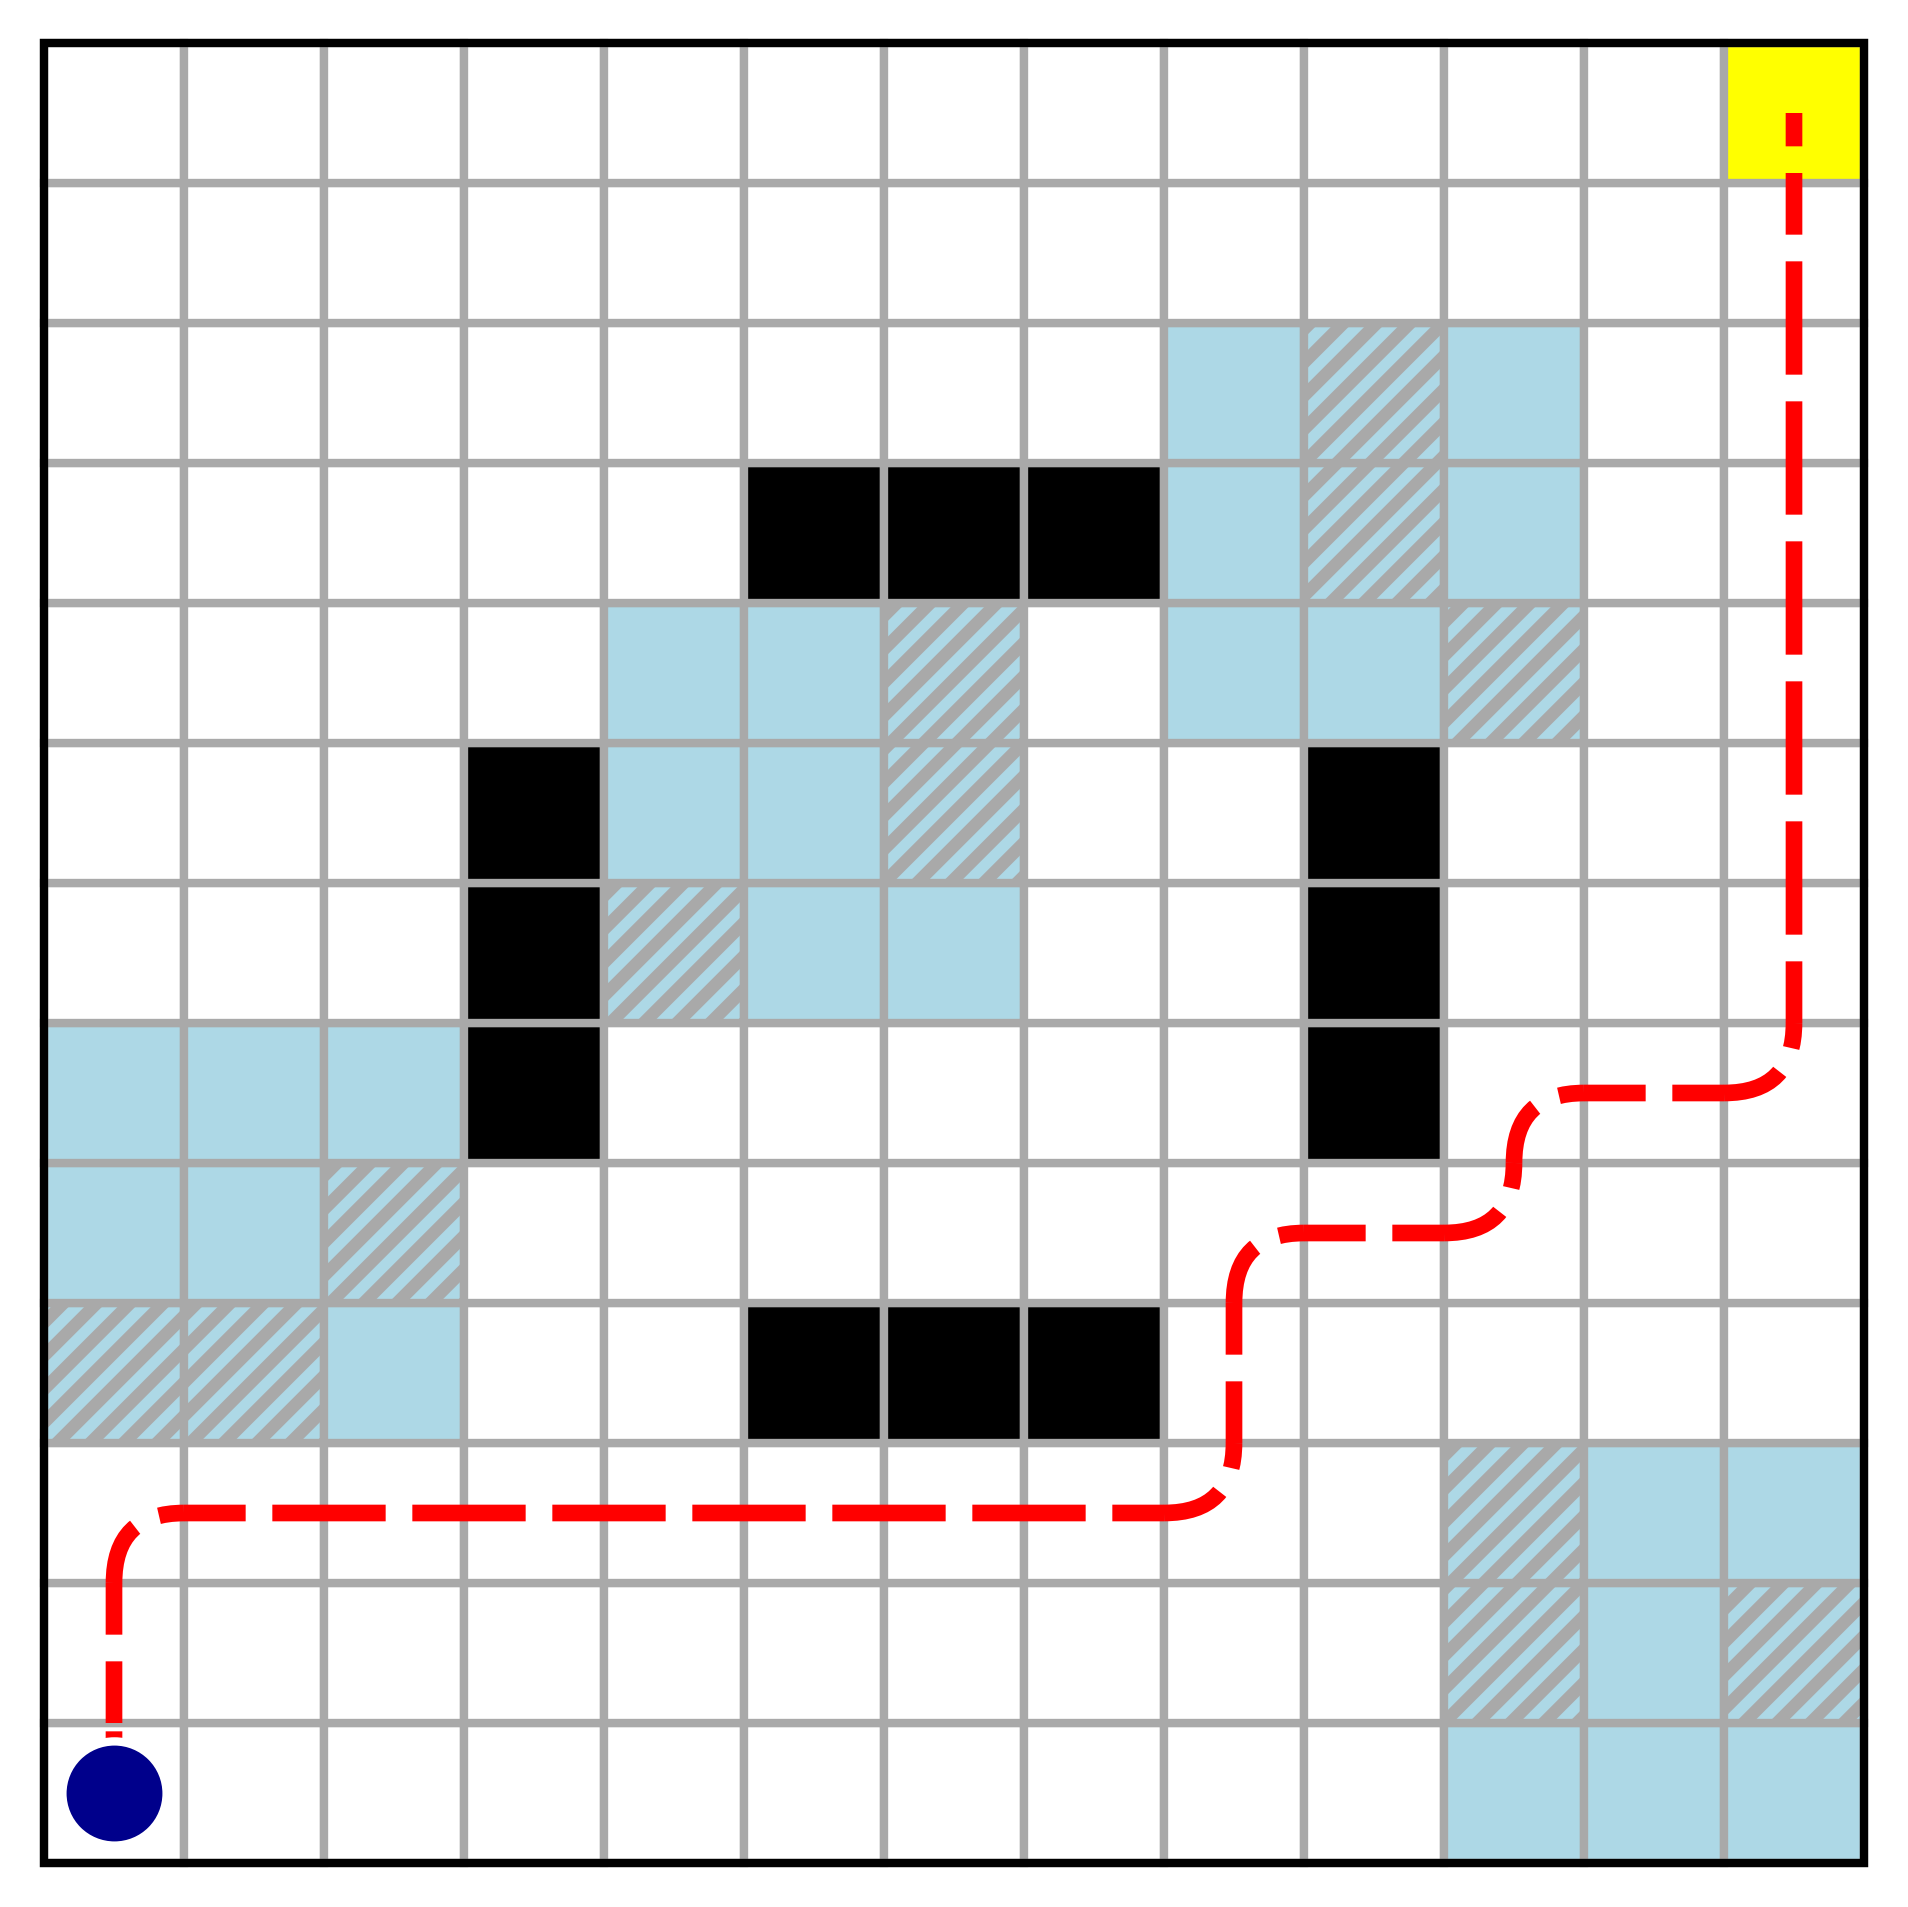

In [125]:
test_maze_stats[0]
fine_maze_stats[0]

coarse_maze_stats[0]['tile_array']

maze_stats = coarse_maze_stats[0]

gw = GridWorld(
    tile_array=maze_stats['tile_array'],
    **{
        **gw_params,
        'wall_features': '#ABCDEFGHIJKabcdefg',
    }
)
fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=300)
true_gwp = gw.plot(
    ax=ax,
    featurecolors={
        **{c: MAIN_OBSTACLE_COLOR for c in "ABCDEFG"},
        **{c: BROKEN_OBSTACLE_COLOR for c in "abcdefg"},
        "#": 'k',
        '$': 'yellow'
    },
    plot_walls=False,
    plot_initial_states=False,
    plot_absorbing_states=False
)
true_gwp.ax.plot(
    .5, .5,
    color='darkblue',
    marker='o',
    markersize=25,
    markeredgewidth=2,
    mec='w',
)

fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=300)
plot_wall_array(
    maze_stats['coarse_wall_arr'], gw_params, maze_stats['tile_array'], 
    ax=ax,
)
construal_gwp = GridWorldPlotter(gw, ax=ax)

traj = PolicyIteration().plan_on(gw).policy.run_on(gw, rng=random.Random(12319))
construal_gwp.plot_trajectory(traj.state_traj, lw=4, ls='--', color='r', jitter_mean=.0, jitter_var=0)
construal_gwp.ax.plot(
    .5, .5,
    color='darkblue',
    marker='o',
    markersize=25,
    markeredgewidth=2,
    mec='w',
)

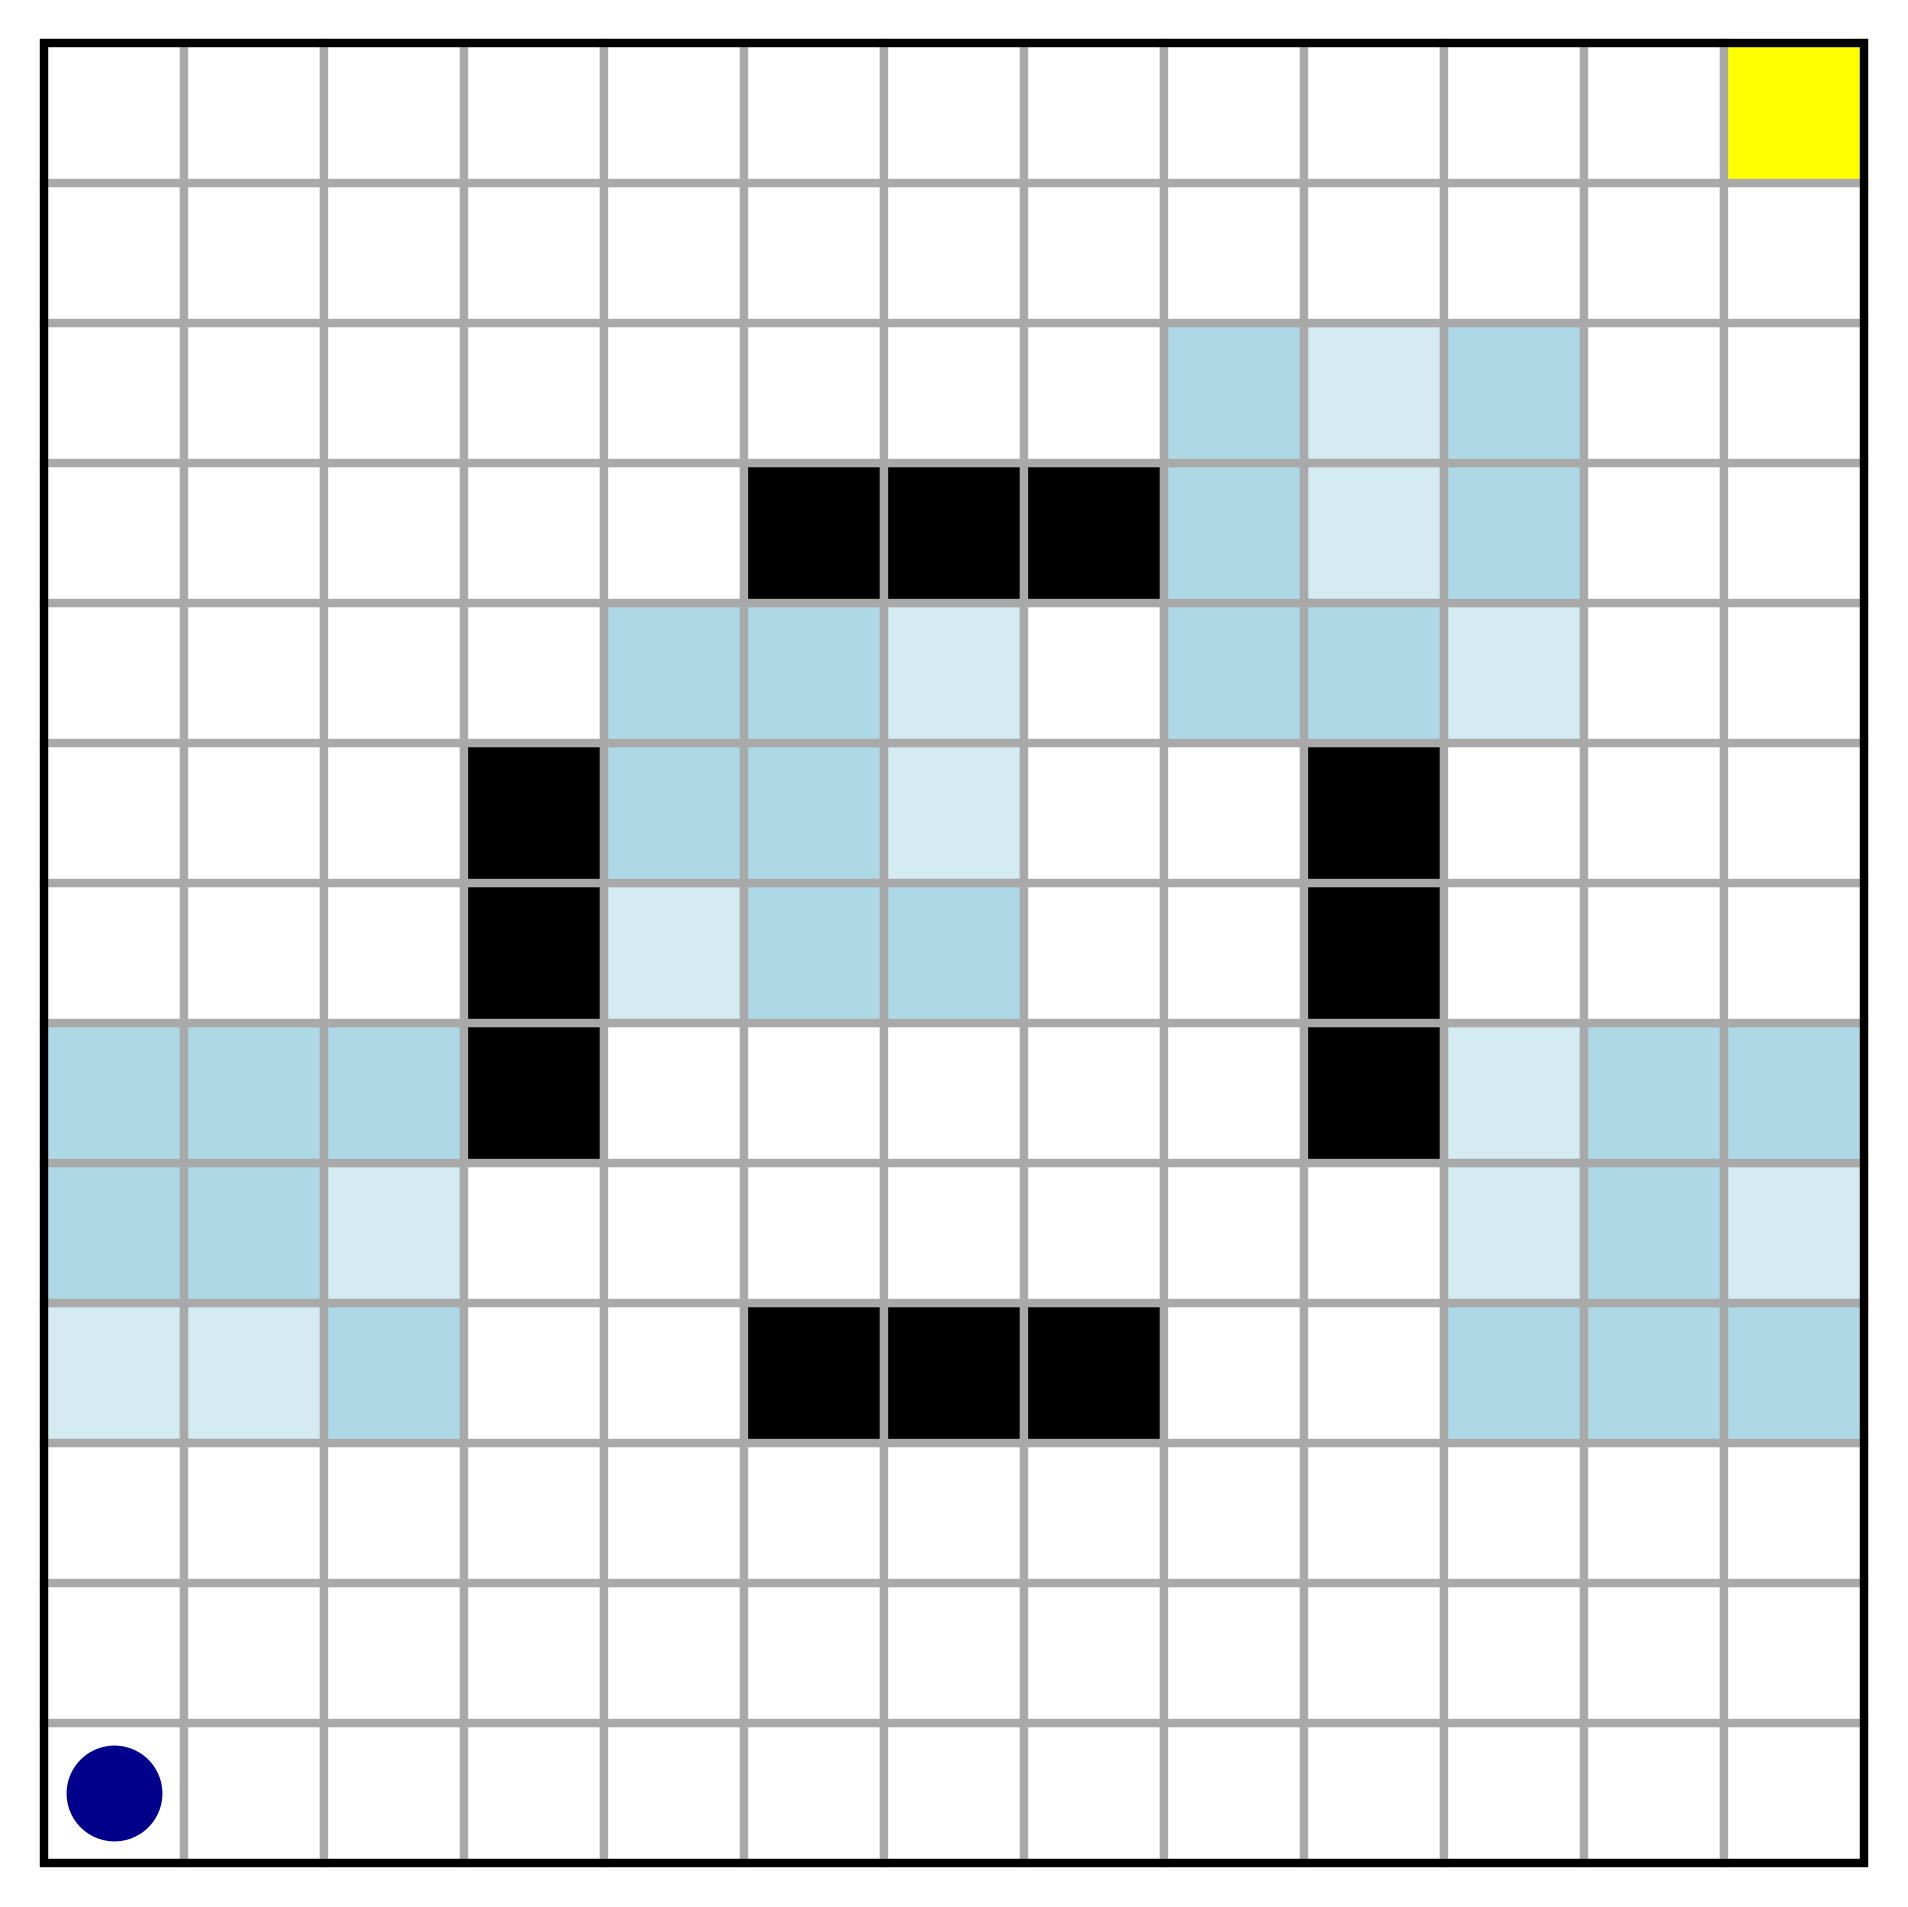

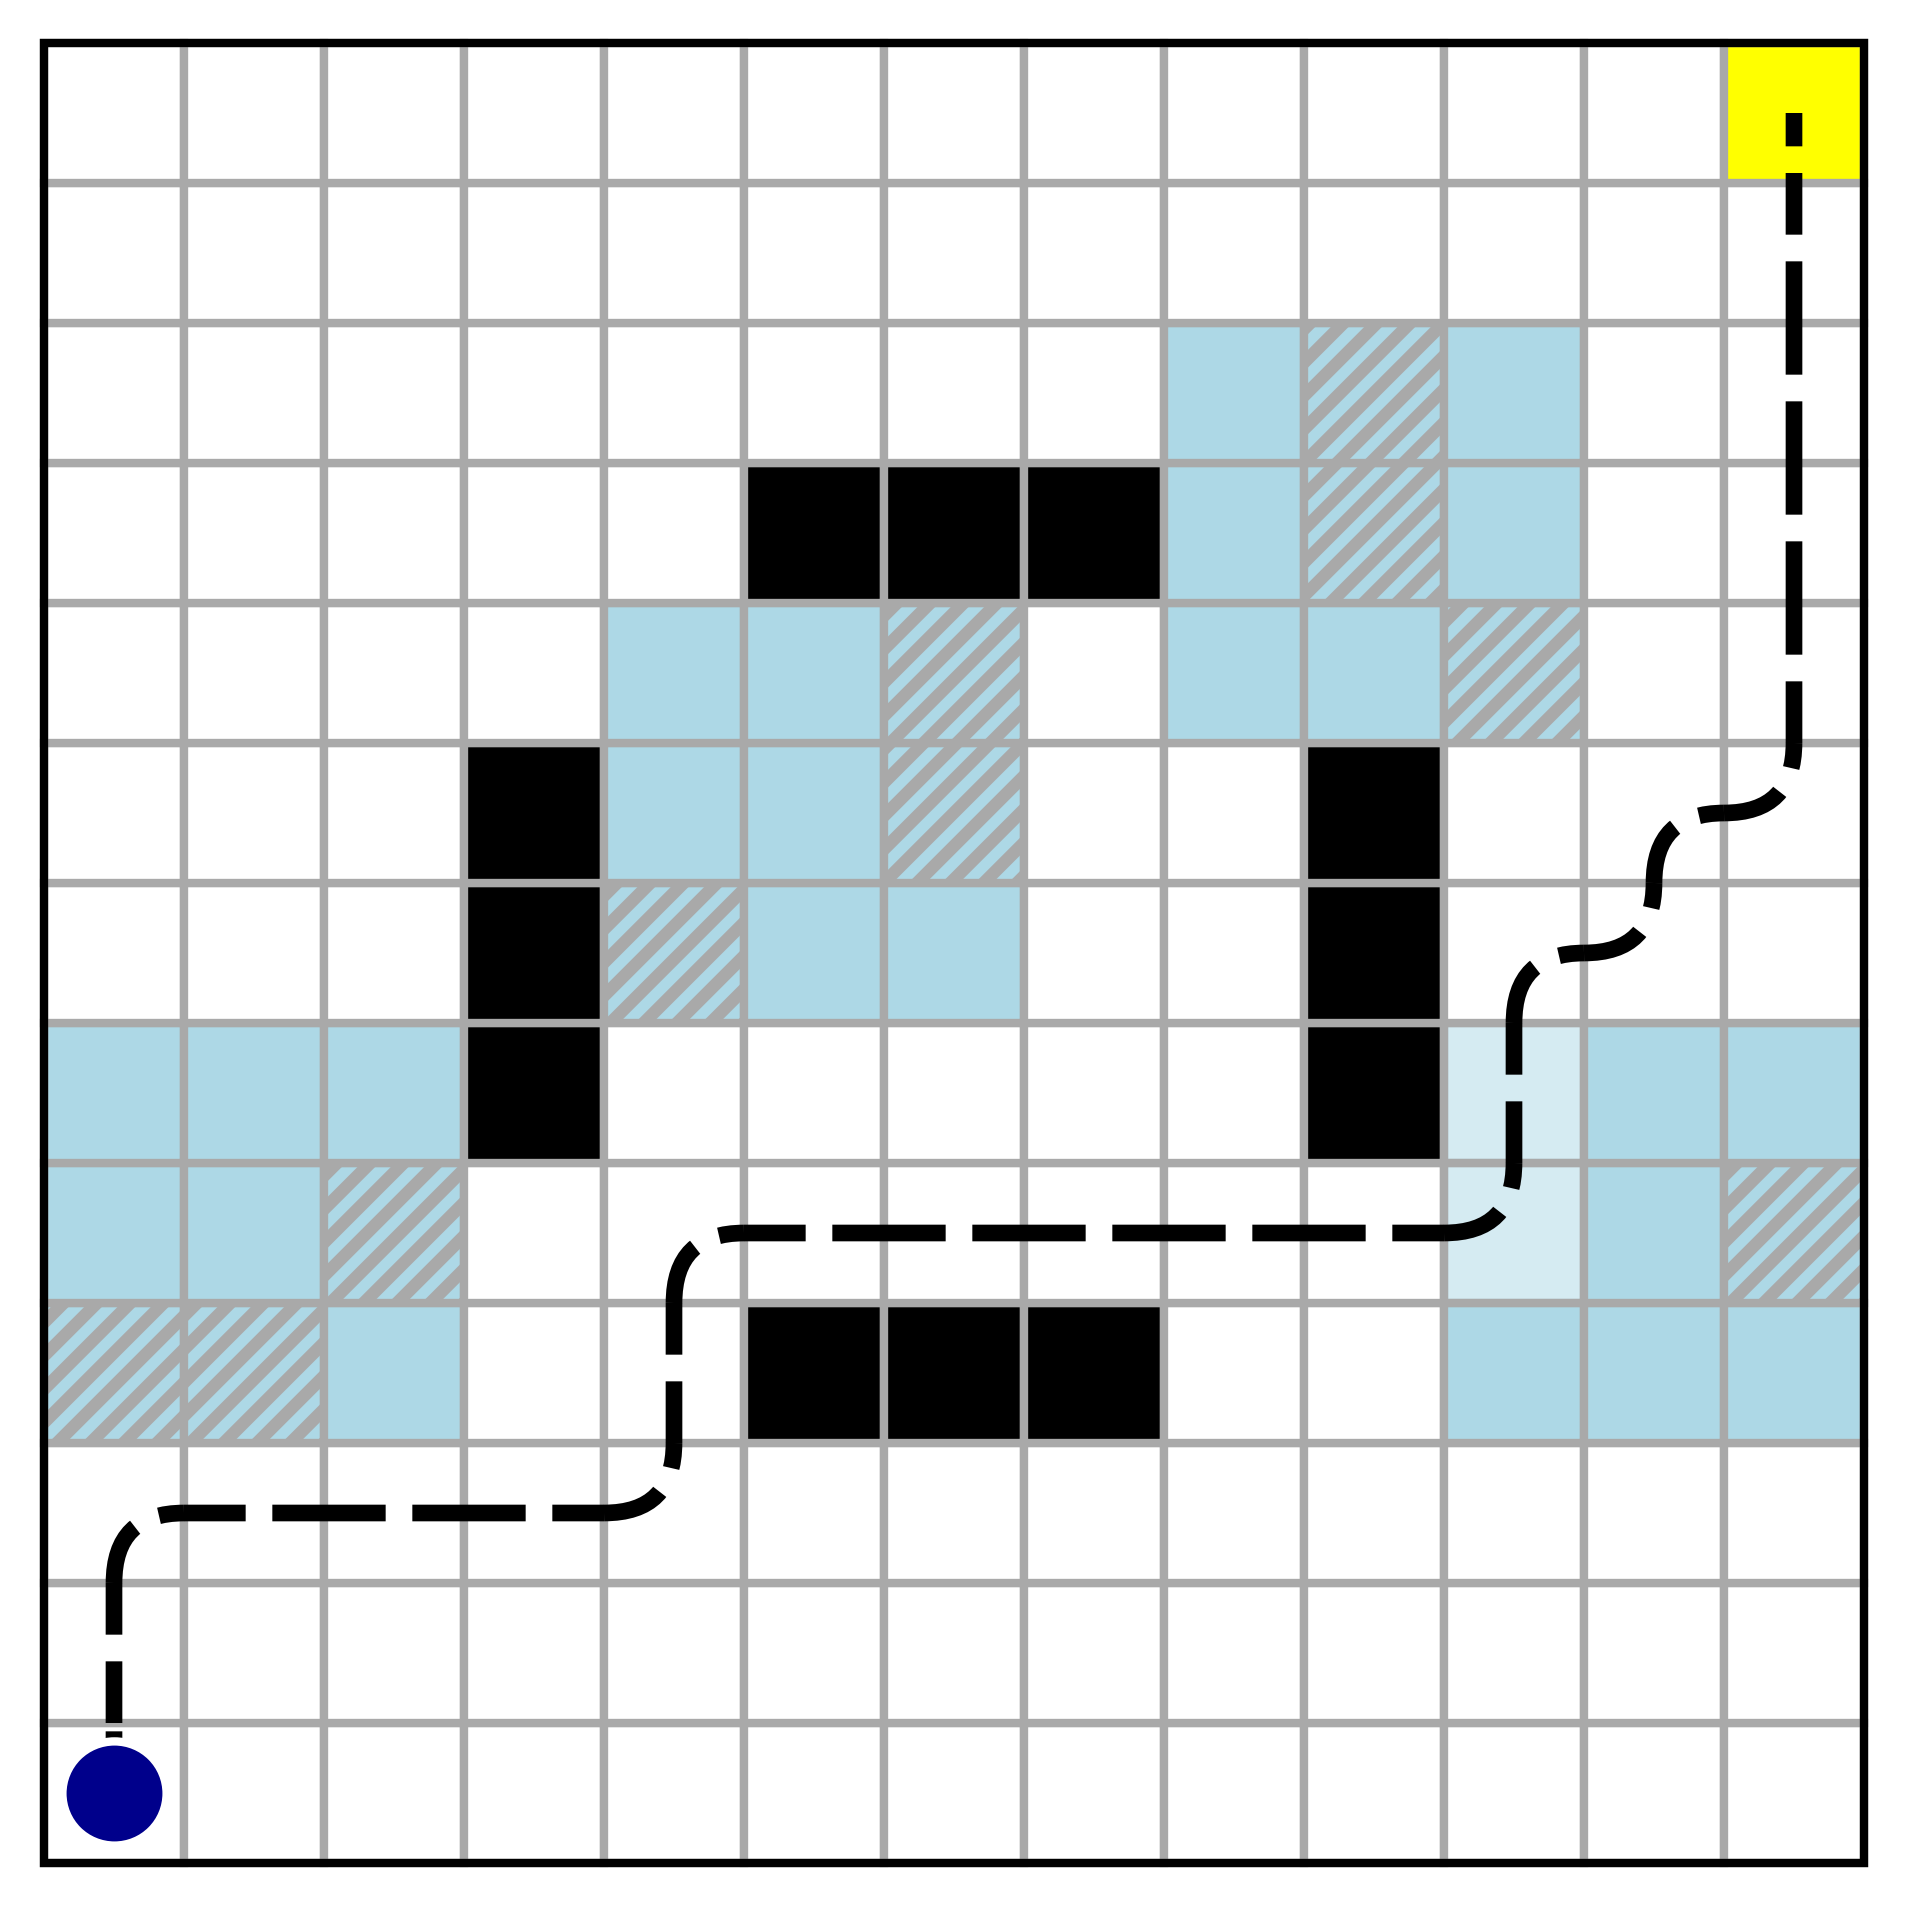

In [126]:

maze_stats = fine_maze_stats[0]

gw = GridWorld(
    tile_array=maze_stats['tile_array'],
    **{
        **gw_params,
        'wall_features': '#ABCDEFGHIJK',
    }
)
fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=300)
true_gwp = gw.plot(
    ax=ax,
    featurecolors={
        **{c: MAIN_OBSTACLE_COLOR for c in "ABCDEFG"},
        **{c: BROKEN_OBSTACLE_COLOR for c in "abcdefg"},
        "#": 'k',
        '$': 'yellow'
    },
    plot_walls=False,
    plot_initial_states=False,
    plot_absorbing_states=False
)
true_gwp.ax.plot(
    .5, .5,
    color='darkblue',
    marker='o',
    markersize=25,
    markeredgewidth=2,
    mec='w',
)

fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=300)
plot_wall_array(
    maze_stats['fine_wall_arr'], gw_params, maze_stats['tile_array'], 
    ax=ax,
)
construal_gwp = GridWorldPlotter(gw, ax=ax)

traj = PolicyIteration(max_iterations=200).plan_on(gw).policy.run_on(gw, rng=random.Random(15319))
construal_gwp.plot_trajectory(traj.state_traj, lw=4, ls='--', color='k', jitter_mean=.0, jitter_var=0)
construal_gwp.ax.plot(
    .5, .5,
    color='darkblue',
    marker='o',
    markersize=25,
    markeredgewidth=2,
    mec='w',
)

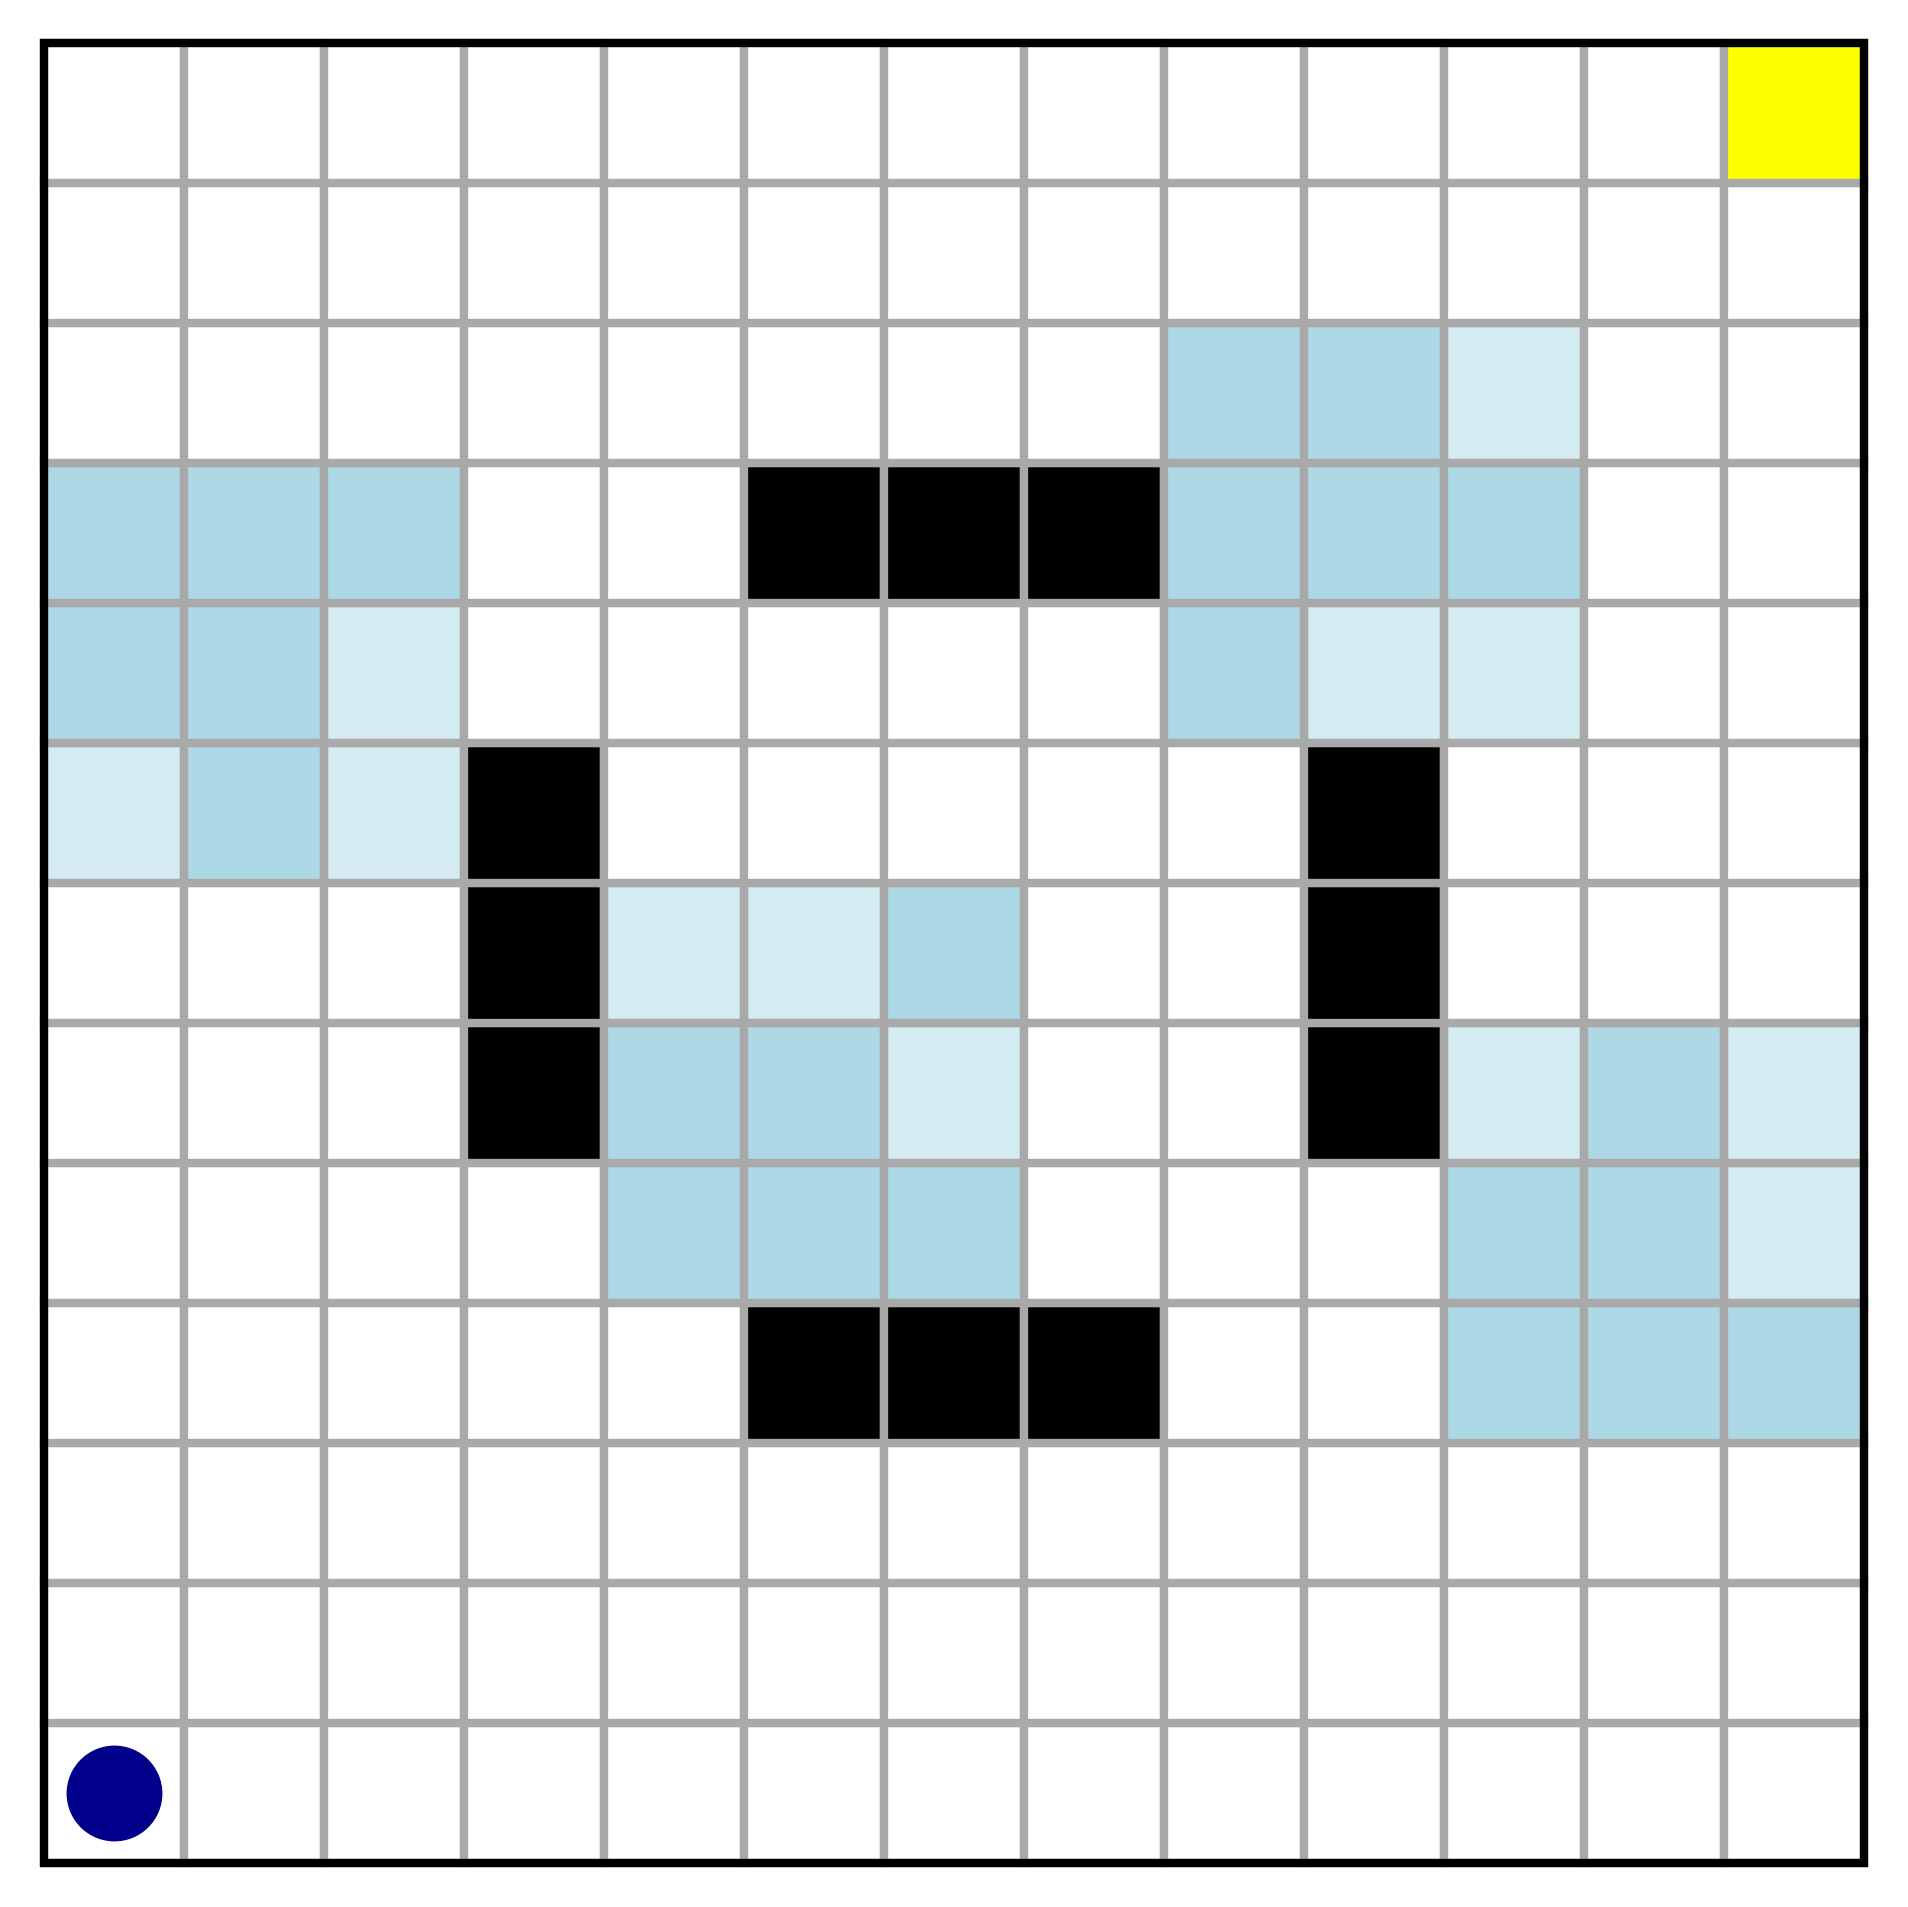

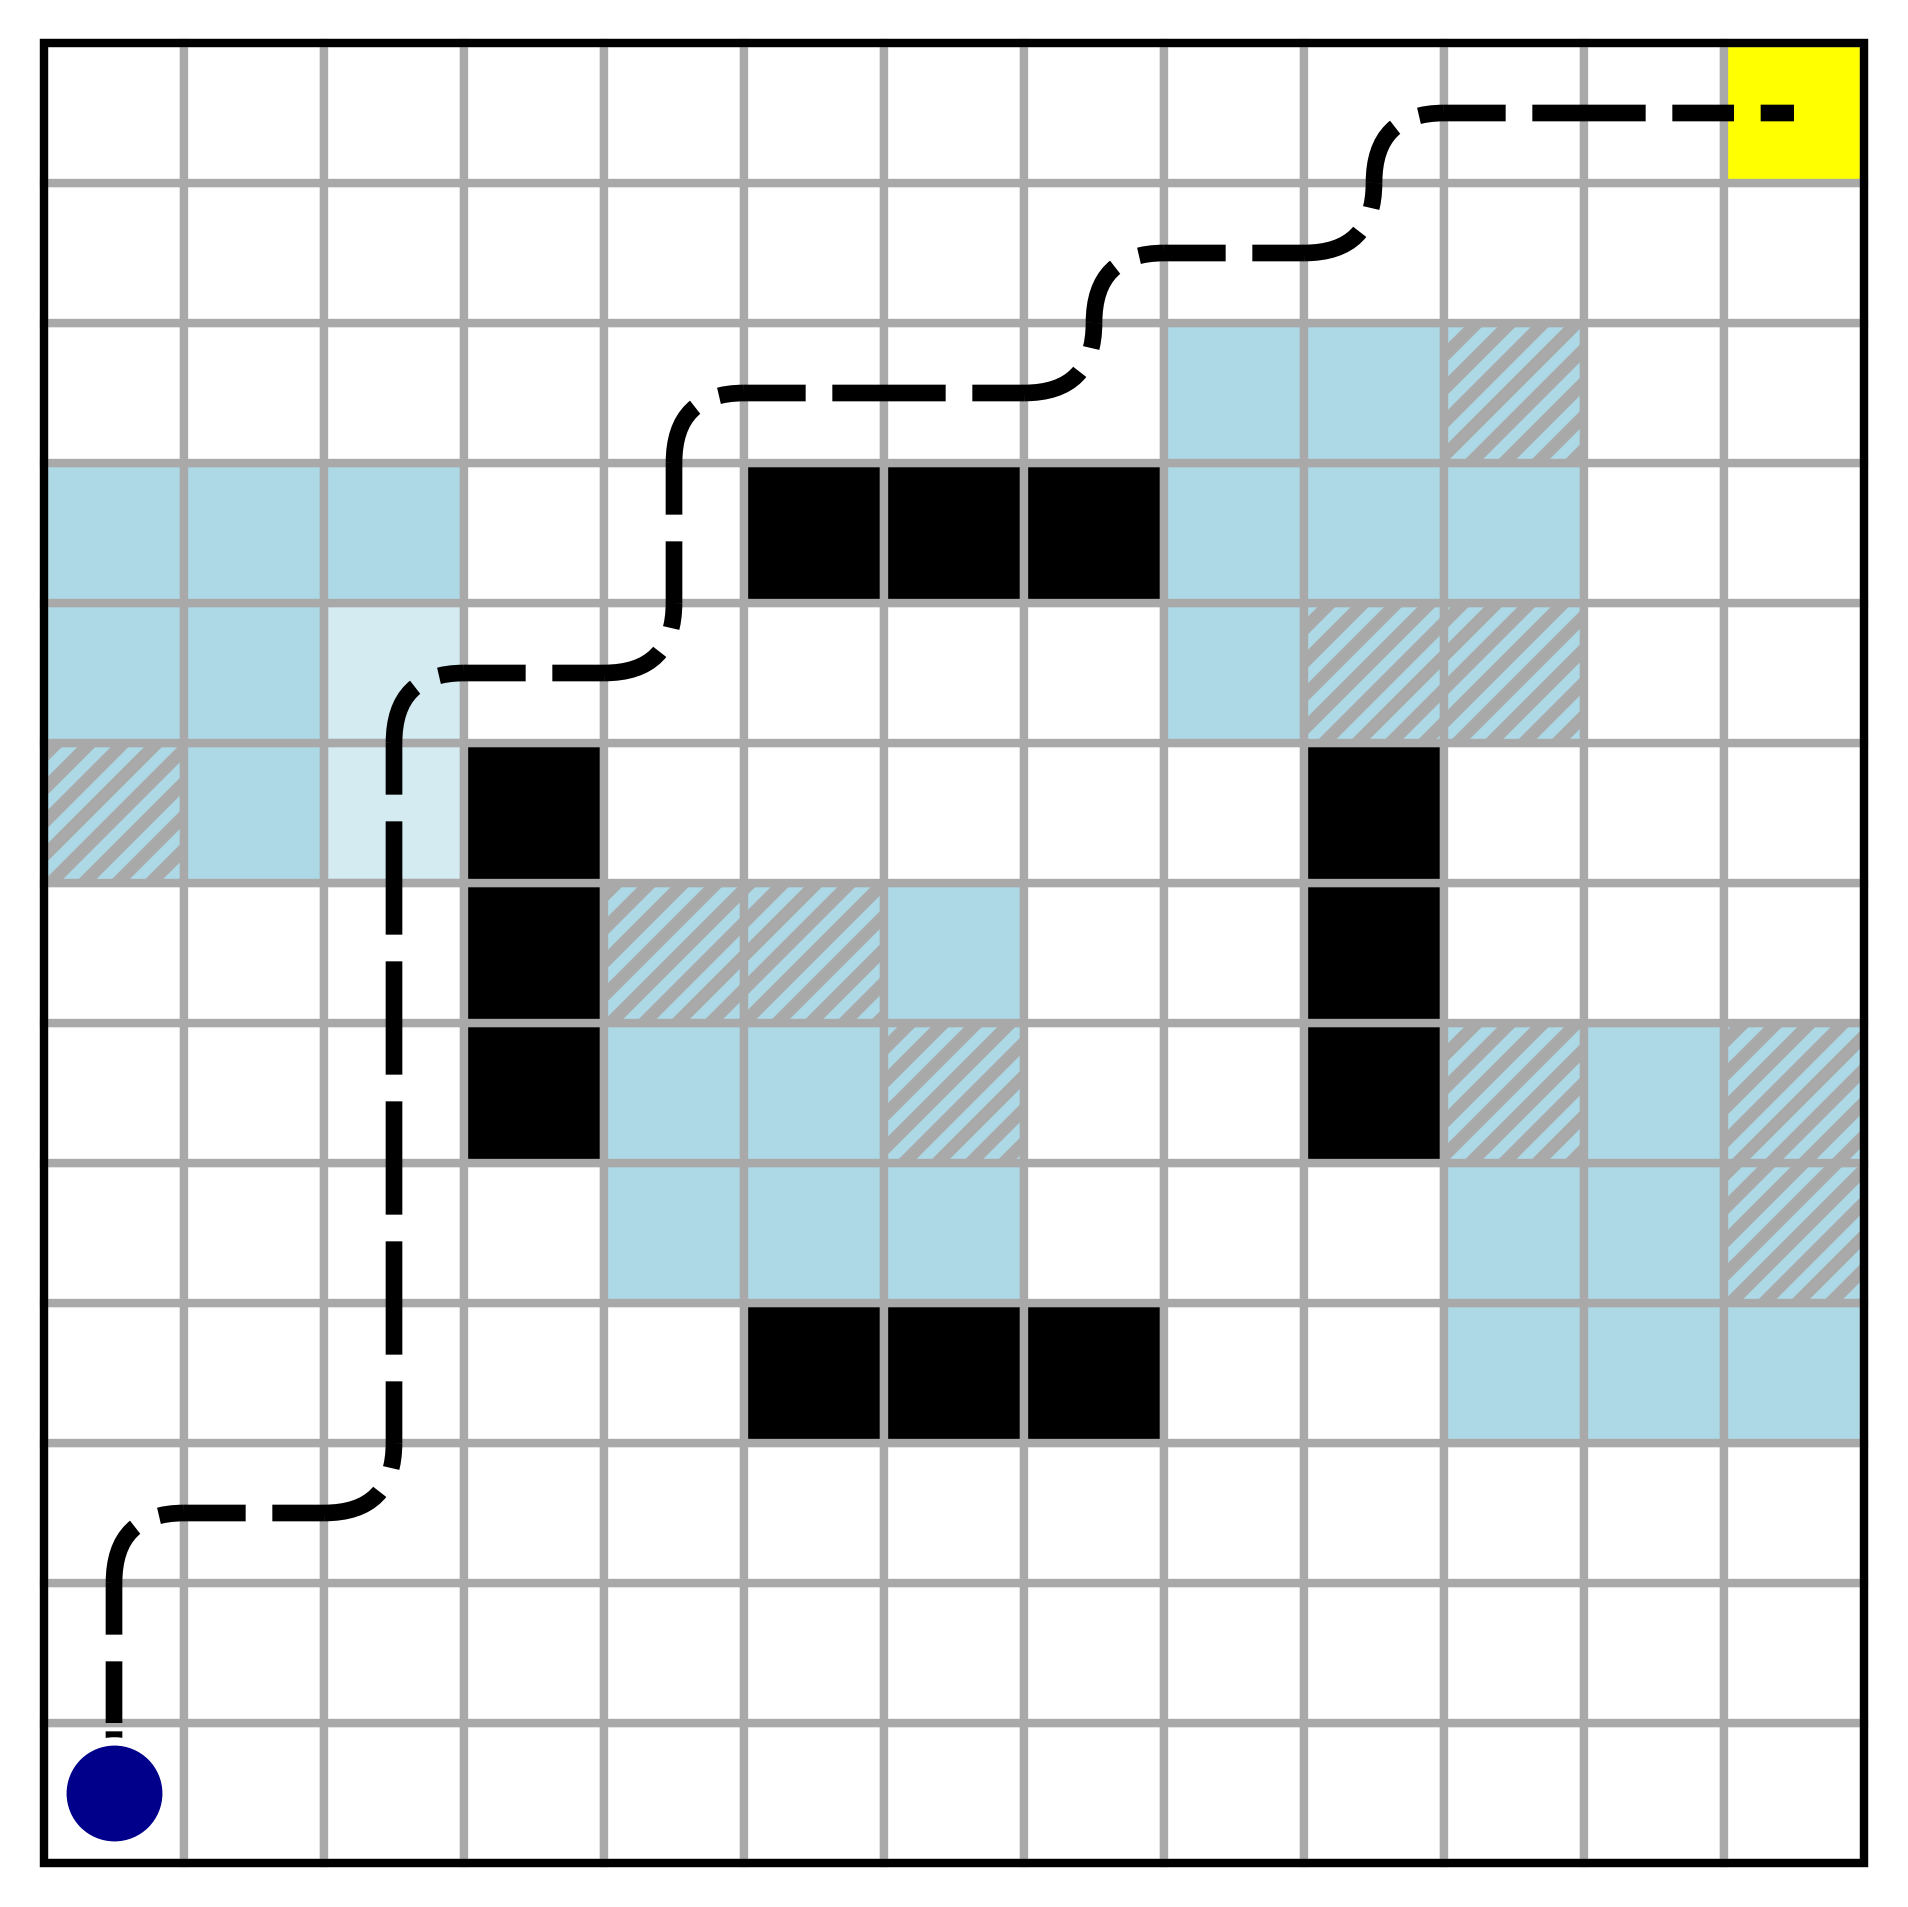

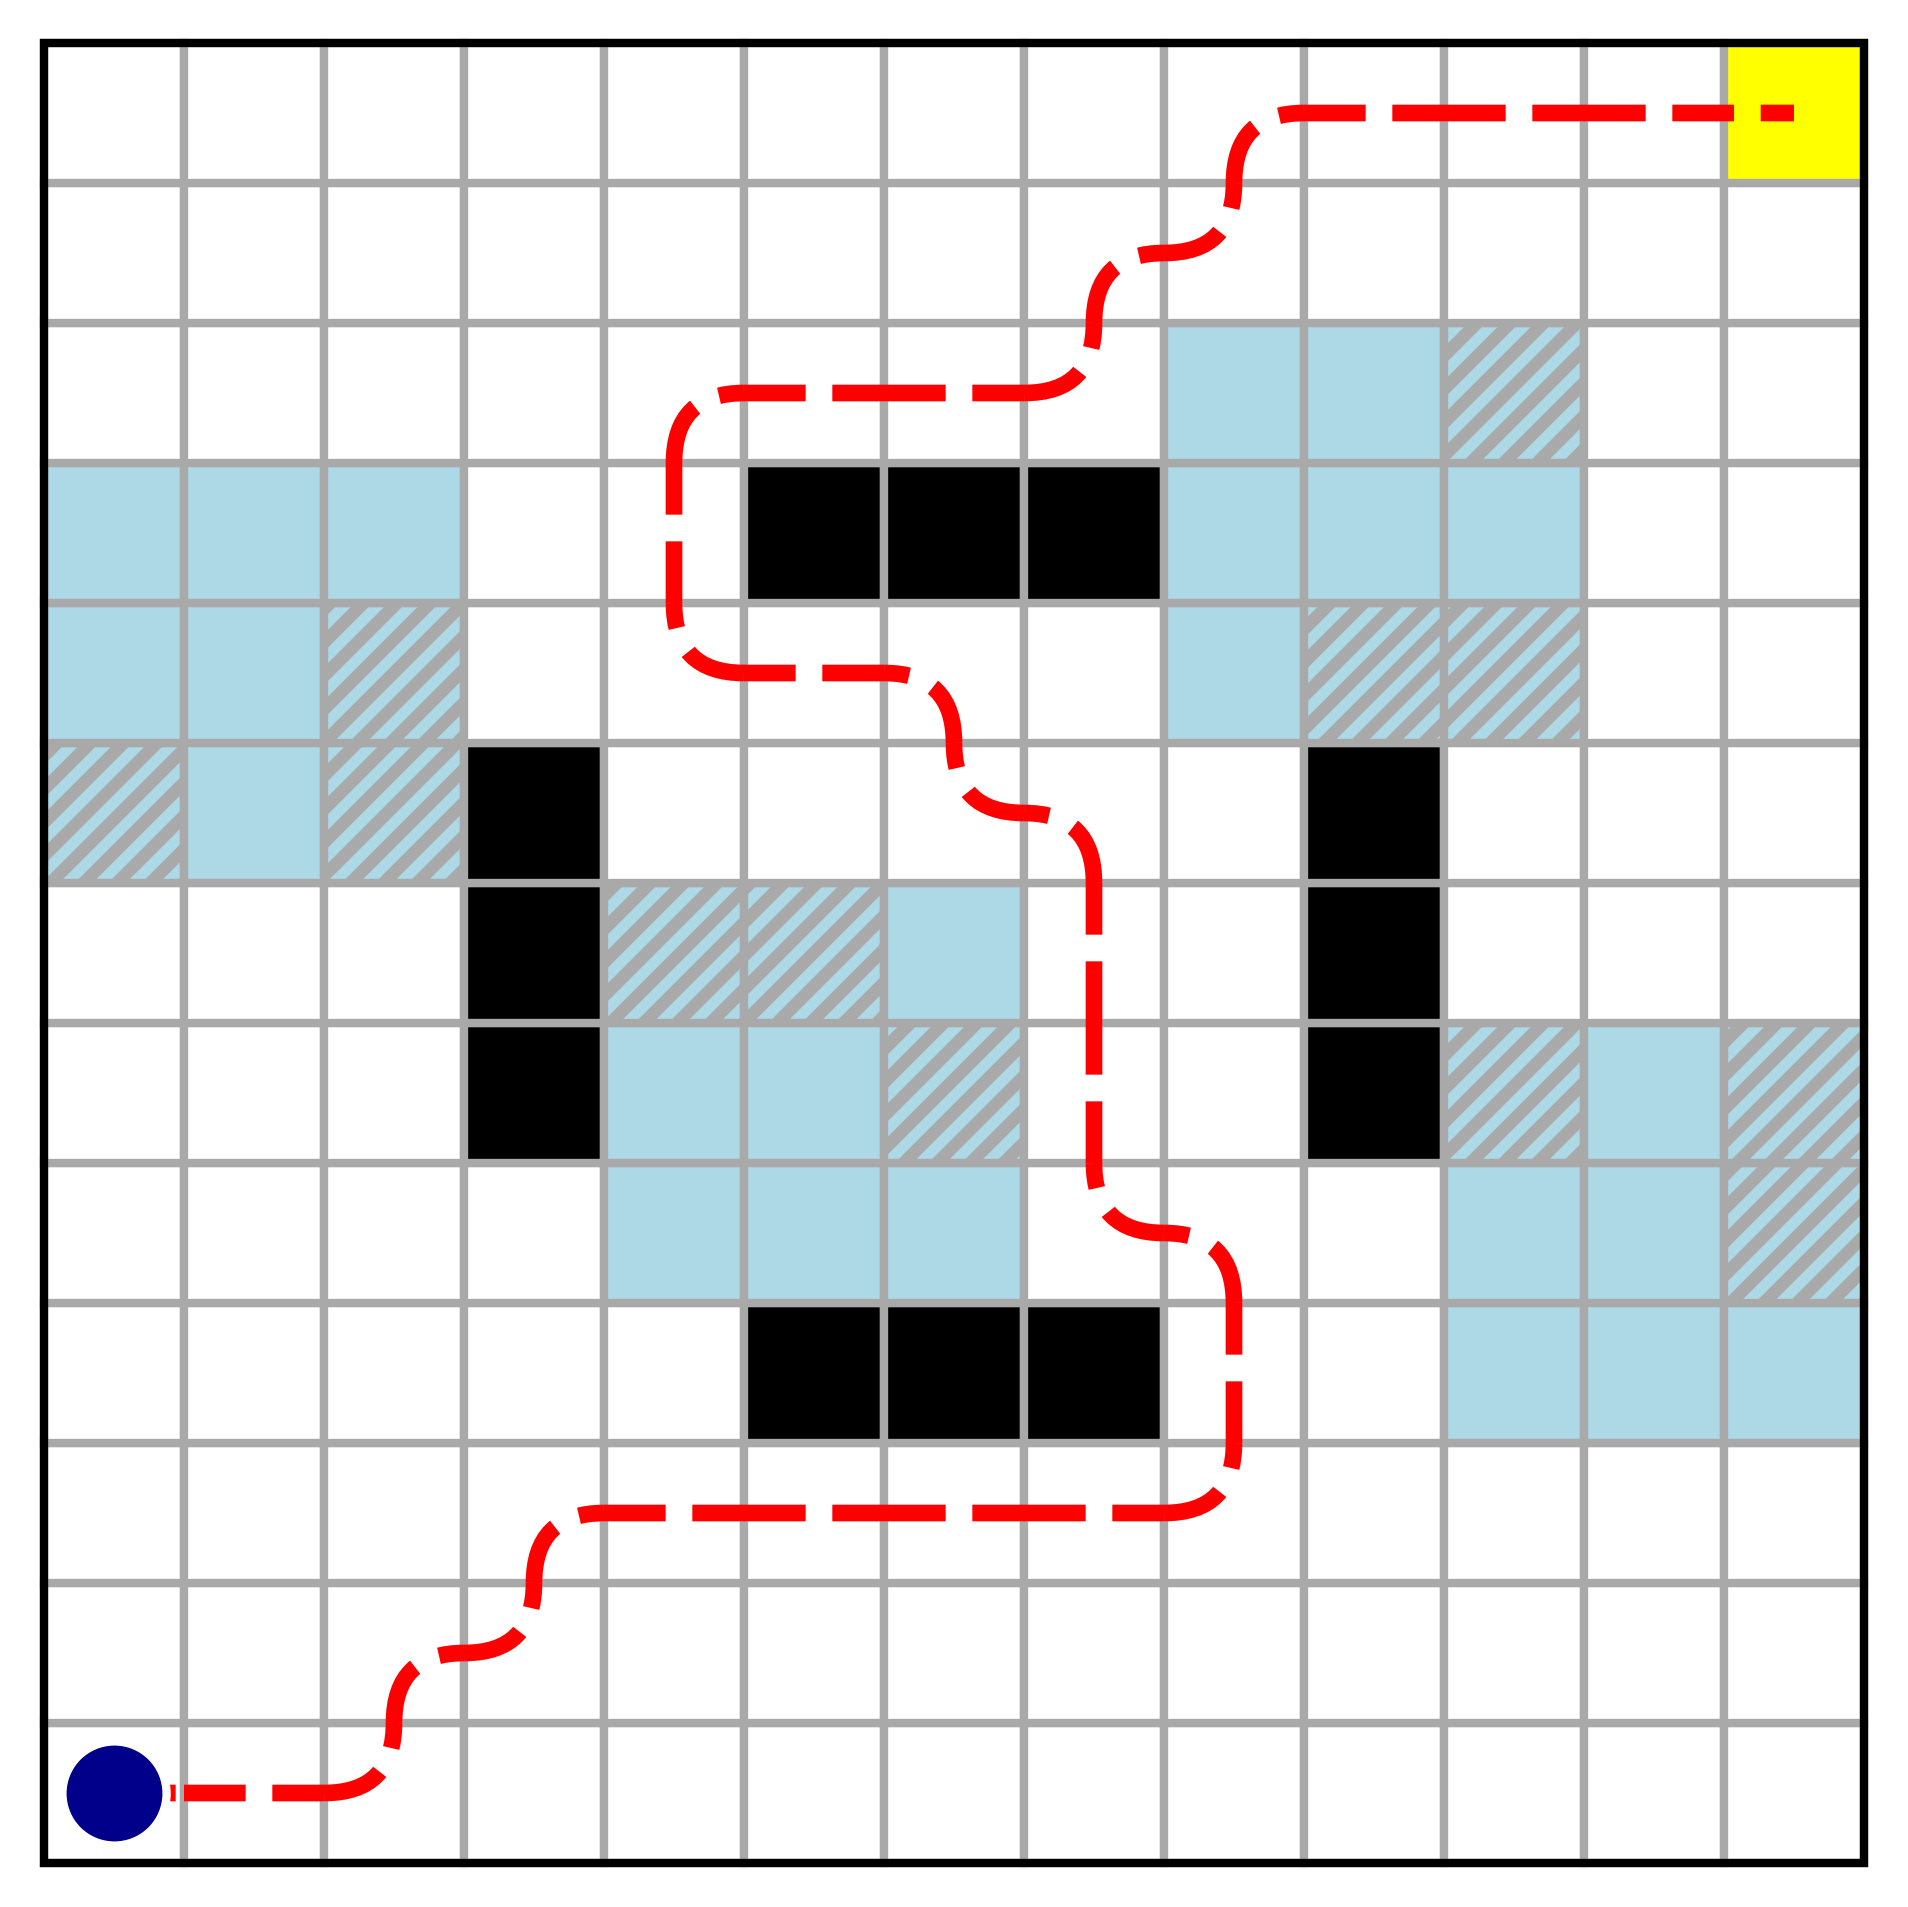

In [134]:

maze_stats = test_maze_stats[0]

notch_gw = GridWorld(
    tile_array=maze_stats['tile_array'],
    **{
        **gw_params,
        'wall_features': '#ABCDEFGHIJK',
    }
)
block_gw = GridWorld(
    tile_array=maze_stats['tile_array'],
    **{
        **gw_params,
        'wall_features': '#ABCDEFGHIJKabcdefg',
    }
)
fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=300)
true_gwp = notch_gw.plot(
    ax=ax,
    featurecolors={
        **{c: MAIN_OBSTACLE_COLOR for c in "ABCDEFG"},
        **{c: BROKEN_OBSTACLE_COLOR for c in "abcdefg"},
        "#": 'k',
        '$': 'yellow'
    },
    plot_walls=False,
    plot_initial_states=False,
    plot_absorbing_states=False
)
true_gwp.ax.plot(
    .5, .5,
    color='darkblue',
    marker='o',
    markersize=25,
    markeredgewidth=2,
    mec='w',
)

fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=300)
plot_wall_array(
    maze_stats['fine_wall_arr'], gw_params, maze_stats['tile_array'], 
    ax=ax,
)
construal_gwp = GridWorldPlotter(gw, ax=ax)

traj = PolicyIteration(max_iterations=200).plan_on(notch_gw).policy.run_on(notch_gw, rng=random.Random(15319))
construal_gwp.plot_trajectory(traj.state_traj, lw=4, ls='--', color='k', jitter_mean=.0, jitter_var=0)
construal_gwp.ax.plot(
    .5, .5,
    color='darkblue',
    marker='o',
    markersize=25,
    markeredgewidth=2,
    mec='w',
)

fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=300)
plot_wall_array(
    maze_stats['coarse_wall_arr'], gw_params, maze_stats['tile_array'], 
    ax=ax,
)
construal_gwp = GridWorldPlotter(gw, ax=ax)

traj = PolicyIteration(max_iterations=200).plan_on(block_gw).policy.run_on(block_gw, rng=random.Random(12133))
construal_gwp.plot_trajectory(traj.state_traj, lw=4, ls='--', color='r', jitter_mean=.0, jitter_var=0)
construal_gwp.ax.plot(
    .5, .5,
    color='darkblue',
    marker='o',
    markersize=25,
    markeredgewidth=2,
    mec='w',
)